## KGB Model LN Auto V2 With LDA and Variable Reduction

In [1]:
!pip install xgboost


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Train_Binned_Data_260324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Test_Binned_Data_260324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Oot_Binned_Data_260324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Mono_Data/3_Auto_Ttd_Binned_Data_260324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [6]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [7]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [8]:
Train[all_cols].head()

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,319468,Tower,2017-04-13,1.0,1.0,857.0,NaN,0.0,Auto,777.0,789.0,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf

In [9]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [10]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 144))

In [11]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    146855.000000
mean          1.669488
std           0.586060
min           1.060974
50%           1.487468
90%           2.326326
95%           2.722267
99%           3.905550
max          14.347176
Name: wt2, dtype: float64

In [12]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,27867,1.095290,1.583894,8.997074
Bethpage,8328,1.060974,1.453413,5.114712
CPM,6702,1.110488,1.601482,6.383648
GESA,19768,1.101697,1.810696,9.780985
Guardian,19177,1.101219,1.931245,13.497463
HFCU,2044,1.117645,1.662495,8.340647
Hawaii,1438,1.091428,1.775832,8.729644
NCU,595,1.142343,1.784662,5.058578
Numerica,18091,1.096292,1.770058,12.683987


In [13]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [14]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [15]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [16]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(str)]

In [17]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     141943
[1]       4543
[2]        337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
[0]     60829
[1]      1941
[2]       157
[-1]       11
Name: count, dtype: int64
bankruptcystatus
[0]     35903
[1]      1132
[2]        84
[-1]        2
Name: count, dtype: int64
bankruptcystatus
[0]     648409
[1]      33203
[2]       3175
[-1]       428
Name: count, dtype: int64


In [18]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
assetpropcurrenttaxtotal           0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
assetpropcurrentcount              0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
a

In [19]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_4/'

In [20]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(146855.0, (146855, 145), 2227.0, 0.015164618160770828)

In [21]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(62938.0, (62938, 145), 959.0, 0.015237217579204931)

In [22]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [23]:
# df_bv= pd.DataFrame()

# for col in req_cols:
#     print(col)
#     ### Train
#     temp_tr= Train.groupby(col).agg(
#         bad_count_tr= ('bad_flag', 'sum'),
#         bad_rate_tr= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_tr= ('p1', 'mean'),
#                                    volume_tr= ('unique_id', 'count')).reset_index()
#     temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
#     temp_tr.insert(0, 'variable', col)
    
#     # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
#     # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
#     # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
#     ### Test
#     temp_te= Test.groupby(col).agg(
#         bad_count_te= ('bad_flag', 'sum'),
#         bad_rate_te= ('bad_flag', 'mean'),
#                                 # p1_bad_rate_te= ('p1', 'mean'),
#                                   volume_te= ('unique_id', 'count')).reset_index()
#     temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
#     #temp_te['variable']= col
    
#     # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
#     # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
#     # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
#     # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
#     ### Concatenating
#     temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
#     # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
#     temp= Bucket_Order(temp)
#     # display(temp)
    
#     df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
#     del temp, temp_tr, temp_te

In [24]:
# df_bv.head()

In [25]:
# var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
# var_trend_break, len(var_trend_break)

In [26]:
var_trend_break= ['assetpropnewestsaleprice',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'assetpropcurrenttaxtotal',
  'addrcurrenttractratio',
  'businessassociationtimeoldest',
  'derogtimenewest',
  'educationinstitutionprivate',
  'addrinputavmratio60monthprior',
  'addrcurrentcountyratio',
  'assetpropsaletimeoldest',
  'criminalnonfelonytimenewest',
  'addrcurrentlastsalesprice',
  'evictiontimenewest',
  'bankruptcycount',
  'addrinputtimeoldest',
  'addrcurrentavmratio60monthprior',
  'addrinputavmvalue12month',
  'assetpropsaletimenewest',
  'bankruptcytimenewest',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'lienjudgmentothercount',
  'lienjudgmenttimenewest',
  'sourcecredheadertimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(25, 25)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [27]:
!pip install hyperopt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [28]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [29]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpw2ncmxyv
  JVM stdout: /tmp/tmpw2ncmxyv/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpw2ncmxyv/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_983yb8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.486 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [30]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [31]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(146855, 145) (146855, 145) (62938, 145) (62938, 145) (37121, 144) (685215, 144)


(0.015164618160770828, 0.015237217579204931)

In [32]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [33]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (141943, 145)
[1] (3731, 145)
[2] (1178, 145)
[-1] (3, 145)


In [34]:
train_h2o.head(rows= 2)

unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest,wt2
319468,Tower,2017-04-13 00:00:00,1,1,857,nan,0,Auto,777,789,white,M,Age 62 and over,"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 

In [35]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[1.0, 2.0)","[-inf, 2.0)","[-inf, 10.0)","[0.85, 1.01)",[-1],"[-inf, 510.0)","[280500.0, 363171.0)","[182000.0, 244673.0)","[120570.0, 208000.0)","[131500.0, 299200.0)","[421.0, inf)","[0.436, inf)","[15977.0, 324300.0)","[-inf, 90271.0)",[-1],"[-inf, 23.0)",[-1],"[-inf, 9000.0)","[159.0, inf)","[1.05, 1.47)","[-inf, 2.0)","[1.0, 2.0)","[2.0, inf)","[-inf, 2.0)","[246800.0, inf)","[-inf, 1.0)",[-1],"[0.91, 1.03)",[-1],"[-inf, 1.0)",[-1],[-1],"[1.01, 1.19)",[-1],"[-inf, 9.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[-inf, 1.52)","[0.55, 0.89)",[-1],"[425.0, inf)","[4.755, inf)",[-1],[-1],"[-inf, 683.805)",[-1],[-1],[-1],"[-inf, 0.0352)",[-1],[-1],[-1],"[-inf, 0.0164)","[-inf, 2.0)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)","[1.66, inf)","[-inf, 76843.0)","[-inf, 69000.0)","[0.0, inf)",[0],[1],[0],"[242.0, inf)","[-inf, 1.33)","[256476.0, 313290.0)",[0],[1],[0],[1],[1],[0],[0],[0],"[0.0, inf)",[1],"[247.0, inf)",[1],[1],[0],"[-inf, 0.203)",[1],[-1],"[-inf, 0.07

In [36]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [37]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [38]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [39]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in var_trend_break] #barsath_list_to_drop
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

105

In [40]:
req_cols

['assetpropevercount',
 'sourcenonderogcount06month',
 'addronfilecount',
 'addrinputcountyratio',
 'addrcurrenttaxvalue',
 'addrinputavmvalue',
 'addrinputtaxmarketvalue',
 'sourcecredheadertimeoldest',
 'addrinputphonecount',
 'addrcurrentavmvalue',
 'assetproppurchasetimeoldest',
 'addrpreviouslengthofres',
 'addrinputlengthofres',
 'addrcurrenttaxmarketvalue',
 'addrprevioustimenewest',
 'sourcenonderogcount12month',
 'assetpropcurrentcount',
 'addrinputsubjectcount',
 'sourcenonderogcount',
 'addrinputtaxvalue',
 'assetpropeversoldcount',
 'addrinputtractratio',
 'addrchangecount24month',
 'addrinputtimelastsale',
 'addrinputblockratio',
 'businesstitleleadership',
 'addrcurrentlengthofres',
 'addrcurrentavmratio12monthprior',
 'addrcurrentblockratio',
 'derogcount',
 'profliccount',
 'subjectrecordtimeoldest',
 'addrcurrenttimenewest',
 'proflictypecategory',
 'lienjudgmentdollartotal',
 'addrinputtimenewest',
 'addrcurrenttimelastsale',
 'addrlastmovetaxratiodiff',
 'criminalnon

In [41]:
req_cols= [col for col in req_cols if 'education' not in col]
len(req_cols)

101

In [42]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [43]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id="xgb_auto_wt_segment_with_lda_model_4",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [44]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
CPU times: user 15 s, sys: 997 ms, total: 16 s
Wall time: 1h 11min 12s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_with_lda_model_4


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.019843169411992965
RMSE: 0.14086578510054515
LogLoss: 0.08855365097516665
Mean Per-Class Error: 0.4046289478327654
AUC: 0.806557139089062
AUCPR: 0.1218297826705065
Gini: 0.613114278178124

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08733666910532009
       0       1     Error    Rate
-----  ------  ----  -------  ------------------
0      233861  6076  0.0253   (6076.0/239937.0)
1      4104    1131  0.784    (4104.0/5235.0)
Total  237965  7207  0.0415   (10180.0/245172.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0873367    0.181819  132
max f2                       0.0441957    0.255539  216
max f0point5                 0.140559     0.189233  76
max accuracy                 0.391236     0.978836  5
max precision                0.695415     1         0
max recall                   0.00114388   1         398
max specificity              0.695415     1         0
max absolute_mcc             0.0636144    0.170345  174
max min_per_class_accuracy   0.0247191    0.722725  278
max mean_per_class_accuracy  0.0237602    0.726077  282
max tns                      0.695415     239937    0
max fns                      0.695415     5222.88   0
max fps                      0.000886577  239937    399
max tps                      0.00114388   5235.24   398
max tnr                      0.695415     1         0
max fnr                      0.695415     0.997639  0
max fpr                      0.000886577  1         399
max tpr                      0.00114388   1         398

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.90 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0116105                   0.137178           10.1144    10.1144            0.230329         0.213748    0.230329                    0.213748            0.117433        0.117433                   911.437   911.437            0.108288
2        0.0235919                   0.102418           5.47894    7.76021            0.124769         0.135441    0.176719                    0.173979            0.0656455       0.183078                   447.894   676.021            0.163203
3        0.0351248                   0.086693           4.95415    6.83887            0.112818         0.109687    0.155738                    0.152869            0.0571359       0.240214                   395.415   583.887            0.209868
4        0.0466246                   0.0782002          3.53078    6.02294            0.0804044        0.0977218   0.137157                    0.139268            0.040603        0.280817                   253.078   502.294            0.23965
5        0.0579914                   0.0717639          3.74317    5.57608            0.0852411        0.0900857   0.126981                    0.129627            0.042548        0.323365                   274.317   457.608            0.271558
6        0.113419                    0.0499296          2.67135    4.15654            0.0608331        0.0736673   0.0946546                   0.10228             0.148067        0.471432                   167.135   315.654            0.366356
7        0.168316                    0.0357148          

##### Train Predictions

In [45]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [46]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [47]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030091,0.695415,0.054997,49035.086234,45789.694780,3245.391454,6.62,20.0,19.08,61.99,42.91
1,0.017695,0.030090,0.023423,49035.383747,47944.497739,1090.886008,2.22,40.0,39.07,82.83,43.76
2,0.008578,0.017695,0.012373,49033.169485,48426.635786,606.533699,1.24,60.0,59.25,94.41,35.16
3,0.004524,0.008578,0.006321,49034.918293,48805.049983,229.868310,0.47,80.0,79.59,98.80,19.21
4,0.000510,0.004524,0.002893,49034.096893,48971.534309,62.562584,0.13,100.0,100.00,100.00,0.00


{'Gini': 56.42, 'KS': 43.76}


In [48]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030376,0.396388,0.055329,21027.522236,19717.092594,1310.429642,6.23,20.0,19.16,59.05,39.89
1,0.017658,0.030372,0.023530,21025.281507,20544.020403,481.261104,2.29,40.0,39.12,80.73,41.61
2,0.008582,0.017658,0.012395,21025.686574,20763.754340,261.932233,1.25,60.0,59.30,92.54,33.24
3,0.004473,0.008581,0.006301,21027.190493,20910.483256,116.707236,0.56,80.0,79.62,97.80,18.18
4,0.000481,0.004472,0.002872,21024.951517,20976.041152,48.910364,0.23,100.0,100.00,100.00,0.00


{'Gini': 53.169999999999995, 'KS': 41.61}


#### Non-weighted

In [49]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024023,0.695415,0.044348,29372,27989.0,1383.0,4.71,20.0,19.35,62.10,42.75
1,0.011966,0.024023,0.017660,29370,28893.0,477.0,1.62,40.0,39.33,83.52,44.19
2,0.006578,0.011966,0.008852,29372,29132.0,240.0,0.82,60.0,59.47,94.30,34.83
3,0.003796,0.006577,0.005111,29371,29271.0,100.0,0.34,80.0,79.71,98.79,19.08
4,0.000510,0.003796,0.002522,29370,29343.0,27.0,0.09,100.0,100.00,100.00,0.00


{'Gini': 56.34, 'KS': 44.19}


In [50]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024144,0.396388,0.044601,12588,12027.0,561.0,4.46,20.0,19.40,58.50,39.10
1,0.011985,0.024143,0.017684,12588,12362.0,226.0,1.80,40.0,39.35,82.06,42.71
2,0.006557,0.011985,0.008851,12587,12486.0,101.0,0.80,60.0,59.50,92.60,33.10
3,0.003753,0.006556,0.005061,12588,12544.0,44.0,0.35,80.0,79.74,97.18,17.44
4,0.000481,0.003752,0.002509,12587,12560.0,27.0,0.21,100.0,100.00,100.00,0.00


{'Gini': 52.94, 'KS': 42.71}


In [51]:
Oot['wt2']= 1
TTD['wt2']= 1

In [52]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024115,0.400474,0.044555,7425,7127.0,298.0,4.01,20.0,19.49,54.68,35.19
1,0.012068,0.024113,0.017722,7424,7279.0,145.0,1.95,40.0,39.39,81.28,41.89
2,0.006588,0.012067,0.008921,7424,7366.0,58.0,0.78,60.0,59.53,91.93,32.40
3,0.003796,0.006588,0.005113,7424,7397.0,27.0,0.36,80.0,79.75,96.88,17.13
4,0.000531,0.003796,0.002540,7424,7407.0,17.0,0.23,100.0,100.00,100.00,0.00


{'Gini': 50.63999999999999, 'KS': 41.89}


In [53]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrinputcountyratio', 'addrlastmovetaxratiodiff', 'derogcount', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'criminalnonfelonycount', 'derogcount12month', 'addrinputtaxvalue', 'evictioncount', 'addrprevioustimeoldest', 'sourcevoterregistration', 'addrinputtimenewest', 'addrcurrentavmvalue60month', 'criminalfelonycount', 'addrinputlengthofres', 'addrchangecount03month', 'addrlastmoveecontrajectory', 'inquirycollections12month', 'bankruptcydismissed24month', 'addrcurrentavmvalue', 'lienjudgmentcount', 'inquirybanking12month', 'bankruptcychapter', 'addrinputtaxmarketvalue', 'addrchangecount24month', 'bankruptcystatus', 'addrcurrentdeedmailing', 'addrinputsubjectcount', 'bankruptcycount24month', 'addrcurrentblockratio', 'addrpreviouslengthofres', 'addrinputdeedmailing', 'assetpropnewestmortgagetype', 'addrcur

In [54]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,assetownership.[0],64439.054688,1.000000,0.185514,assetownership
1,inquiryauto12month.[0],63686.500000,0.988321,0.183347,inquiryauto12month
2,inquiryshortterm12month.[0],25874.898438,0.401541,0.074491,inquiryshortterm12month
3,"sourcenonderogcount12month.[-inf, 2.0)",22134.259766,0.343491,0.063722,sourcenonderogcount12month
4,"assetpropevercount.[-inf, 1.0)",16286.637695,0.252745,0.046888,assetpropevercount
5,inquirytelcom12month.[0],14879.653320,0.230910,0.042837,inquirytelcom12month
6,"sourcenonderogcount.[4.0, 5.0)",7655.215820,0.118798,0.022039,sourcenonderogcount
7,"addrinputcountyratio.[1.32, inf)",7466.403809,0.115868,0.021495,addrinputcountyratio
8,"sourcenonderogcount.[5.0, inf)",6610.652344,0.102588,0.019031,sourcenonderogcount
9,"addrlastmovetaxratiodiff.[-inf, 0.166)",6608.235840,0.102550,0.019024,addrlastmovetaxratiodiff


## HyperOpt

In [55]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
col_list = var_imp_list_baseline1
# len(col_list)
# 75
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'derogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'addrinputtaxvalue', 'criminalnonfelonycount', 'evictioncount', 'derogcount12month', 'addrinputtimenewest', 'addrprevioustimeoldest', 'educationprogramattended', 'criminalfelonycount', 'educationattendance', 'addrinputlengthofres', 'addrcurrentblockratio', 'addrinputtaxmarketvalue', 'bankruptcydismissed24month', 'addrchangecount03month', 'inquirycollections12month', 'inquirybanking12month', 'bankruptcychapter', 'addrinputsubjectcount', 'addrchangecount24month', 'addrcurrentdeedmailing', 'addrinputdeedmailing', 'addrchangecount06month', 'lienjudgmentcount', 'lienjudgmentsmallclaimscount', 'addrpreviouslengthofres', 'bankruptcystatus', 'assetpropnewestmortgagetype', 'bankruptcycount24month', 'assetproppurchasetimeoldest', 'assetproppurchasetimenewest', 'criminalnonfelonycount12month', 'assetpersonalcount', 'addrchangecount60month', 'addrinputtimelastsale', 'addrcurrentlengthofres', 'sourcenonderogcount06month', 'subjectrecordtimeoldest', 'assetpropsalepurchaseratio', 'lienjudgmentcourtcount', 'addronfilecollege', 'addrcurrenttimeoldest', 'lienjudgmenttaxcount', 'evictioncount12month', 'businessassociation', 'addrcurrentavmratio12monthprior', 'addrinputsubjectowned', 'sourcecredheadertimeoldest', 'addrinputphoneservice', 'addrinputavmratio12monthprior', 'assetpropcurrentcount', 'addrcurrenttimenewest', 'shorttermloanrequest', 'lienjudgmentdollartotal', 'lienjudgmentcount12month', 'addronfilecount', 'addrinputproblems']
len(col_list)

80

In [56]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [57]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [58]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [59]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,addrcurrenttaxvalue,addrinputavmvalue,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,addrinputtractratio,addrchangecount24month,addrinputtimelastsale,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,lienjudgmentdollartotal,addrinputtimenewest,addrcurrenttimelastsale,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,businessassociation,criminalfelonycount,criminalnonfelonycount12month,derogcount12month,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[3.0, inf)","[2.0, inf)","[10.0, inf)","[-inf, 0.55)","[-inf, 510.0)","[-inf, 97283.0)","[-inf, 4900.0)","[176.0, 253.0)","[-inf, 0.436)","[-inf, 90271.0)","[29.0, 162.0)","[-inf, 23.0)","[113.0, 166.0)","[-inf, 9000.0)","[43.0, 94.0)","[2.0, inf)","[2.0, inf)","[-inf, 1.0)","[5.0, inf)","[-inf, 518.0)","[-inf, 1.0)","[-inf, 0.33)","[-inf, 1.0)",[-1],"[0.11, 0.71)",[-1],"[98.0, 166.0)",[-1],"[0.11, 0.71)","[1.0, inf)","[-inf, 0.0454)","[253.0, 351.0)","[-inf, 4.755)",[-1],"[683.805, inf)","[-inf, 2.581)",[-1],[-1],"[-inf, 0.0164)","[2.0, inf)","[-inf, 0.0404)","[-inf, 0.0865)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],"[0.0, inf)",[1],[0],[0],"[99.0, 165.0)",[-1],[1],[0],[0],[0],[1],[0],[0],[0],"[0.0, inf)",[3],"[89.0, 136.0)",[1],[1],[1],"[0.203, inf)",[1],[-1],"[-inf, 0.0742)","[-inf, 117.0)","[-inf, 0.145)","[-inf, 0.028)",[0],"[-inf, 0.00494)","[-inf, 0.000184)",[0],[0],"[-inf, 0.00304)","[-inf, 0.000926)","[-inf, 0.0141)","[-inf, 0.00494)","[-inf, 0.000524)",[0],[1],[0],[1],[0],[0],"[0.101, inf)","[-inf, 0.0111)","[-inf, 0.0185)","[0.0, inf)","[-inf, 0.0169)","[0.0643, inf)",[0],[0],[0],[1],[1],"[-inf, 1.605)"
"[3.0, inf)","[2.0, inf)","[-inf, 10.0)","[1.32, inf)","[-inf, 510.0)","[280500.0, 363171.0)","[-inf, 4900.0)","[253.0, 353.0)","[-inf, 0.436)","[296257.0, 385000.0)","[239.0, inf)","[87.0, 126.0)","[48.0, 113.0)","[-inf, 9000.0)","[-inf, 15.0)","[2.0, inf)","[1.0, 2.0)","[1.0, 2.0)","[3.0, 4.0)","[-inf, 518.0)","[1.0, inf)","[1.03, 1.16)","[-inf, 1.0)",[-1],"[1.01, 1.19)",[2],"[98.0, 166.0)","[-inf, 1.33)","[1.02, 1.41)","[-inf, 1.0)","[-inf, 0.0454)","[253.0, 351.0)","[-inf, 4.755)",[-1],"[-inf, 683.805)","[-inf, 2.581)",[-1],[-1],"[-inf, 0.0164)","[2.0, inf)","[-inf, 0.0404

In [60]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2, #space['max_depth'] ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id="xgbm_kgb_auto_ln_with_lda_v3",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.1) + ((1-air_ttd['AIR ttd Raceblack'][0])*0.2) + ((1-air_ttd['AIR ttd Racehispanic'][0])*0.2)
    # loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [61]:
space = {
    # 'max_depth' : hp.choice('max_depth', range(1, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,4000,50)),    
    'min_child_weight' : hp.quniform('min_child_weight', 30, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1,0.6,0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 0.9, 0.05),
    'reg_lambda': hp.quniform('reg_lambda',1,35,0.25),
    'reg_alpha': hp.quniform('reg_alpha',1,50,0.25),
        'gamma':hp.quniform('gamma',1,55,0.25),
            'colsample_bylevel':hp.quniform('colsample_bylevel',0.1, 0.9, 0.05)}

In [62]:
# space = {
#     'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
#     'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
#     'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
#     'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#     'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
#     'gamma':hp.quniform('gamma',5,35,0.5),
#     'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
# #     'seed':42
# }

In [63]:
trials = Trials()

In [ ]:
%%time
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=250,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
█                                                      
█                                                      
█████████████████████████████████████████████████| (done) 100%
  0%|          | 0/250 [04:41<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022265,0.029589,0.000531,0.005077,0.01252,0.027184,0.604872


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60493, 'approved_control': 340538}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49546, 'approved_control': 253026}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27438, 'approved_control': 253026}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22108, 'approved_control': 253026}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149107, 'approved_control': 229006}
{'AIR ttd age_cuts': [1.4322], 'AIR ttd Race': [0.652], 'AIR ttd Raceblack': [0.6871], 'AIR ttd Racehispanic': [0.6131], 'AIR ttd Gender': [0.9353]}
{'loss': 0.22500762957580783, 'status': 'ok', 'KS_diff': 2.0700000000000003, 'train_ks': 44.25, 'test_ks': 42.18, 'gini_diff': 3.7100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021982,0.02021,0.004917,0.008167,0.015449,0.027346,0.175038


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61445, 'approved_control': 339607}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52031, 'approved_control': 250990}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28448, 'approved_control': 250990}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23583, 'approved_control': 250990}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148401, 'approved_control': 229725}
{'AIR ttd age_cuts': [1.4588], 'AIR ttd Race': [0.6901], 'AIR ttd Raceblack': [0.7181], 'AIR ttd Racehispanic': [0.6592], 'AIR ttd Gender': [0.9281]}
{'loss': 0.2029154841814067, 'status': 'ok', 'KS_diff': 0.3299999999999983, 'train_ks': 40.46, 'test_ks': 40.13, 'gini_diff': 0.6499999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022078,0.025542,0.002709,0.006595,0.013114,0.026863,0.298612


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61623, 'approved_control': 339440}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51531, 'approved_control': 251416}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28257, 'approved_control': 251416}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23274, 'approved_control': 251416}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148948, 'approved_control': 229334}
{'AIR ttd age_cuts': [1.4639], 'AIR ttd Race': [0.6823], 'AIR ttd Raceblack': [0.712], 'AIR ttd Racehispanic': [0.6493], 'AIR ttd Gender': [0.9331]}
{'loss': 0.2067347544884183, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 41.42, 'test_ks': 41.1, 'gini_diff': 1.410000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021996,0.022406,0.003579,0.006814,0.013947,0.027937,0.201013


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61107, 'approved_control': 339979}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52167, 'approved_control': 250876}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28569, 'approved_control': 250876}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23598, 'approved_control': 250876}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149442, 'approved_control': 228767}
{'AIR ttd age_cuts': [1.4492], 'AIR ttd Race': [0.6923], 'AIR ttd Raceblack': [0.7215], 'AIR ttd Racehispanic': [0.6598], 'AIR ttd Gender': [0.9385]}
{'loss': 0.2014874096221836, 'status': 'ok', 'KS_diff': 0.9499999999999957, 'train_ks': 40.69, 'test_ks': 39.74, 'gini_diff': 0.9000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021988,0.018005,0.007058,0.009175,0.017776,0.026244,0.088904


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61622, 'approved_control': 339291}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52856, 'approved_control': 250132}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28482, 'approved_control': 250132}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24374, 'approved_control': 250132}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149342, 'approved_control': 229010}
{'AIR ttd age_cuts': [1.4644], 'AIR ttd Race': [0.7035], 'AIR ttd Raceblack': [0.7214], 'AIR ttd Racehispanic': [0.6836], 'AIR ttd Gender': [0.9368]}
{'loss': 0.19665878343442872, 'status': 'ok', 'KS_diff': 0.38000000000000256, 'train_ks': 38.29, 'test_ks': 38.67, 'gini_diff': 0.12000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022095,0.019872,0.006562,0.008488,0.015973,0.025668,0.100825


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62031, 'approved_control': 338774}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53544, 'approved_control': 249253}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29167, 'approved_control': 249253}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24377, 'approved_control': 249253}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147436, 'approved_control': 230953}
{'AIR ttd age_cuts': [1.4762], 'AIR ttd Race': [0.715], 'AIR ttd Raceblack': [0.7414], 'AIR ttd Racehispanic': [0.6861], 'AIR ttd Gender': [0.9171]}
{'loss': 0.1912497664121302, 'status': 'ok', 'KS_diff': 1.4399999999999977, 'train_ks': 37.79, 'test_ks': 39.23, 'gini_diff': 1.64999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022169,0.018757,0.006795,0.009127,0.0167,0.026406,0.09519


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61380, 'approved_control': 339480}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53210, 'approved_control': 249587}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29021, 'approved_control': 249587}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24189, 'approved_control': 249587}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148476, 'approved_control': 229878}
{'AIR ttd age_cuts': [1.4579], 'AIR ttd Race': [0.7098], 'AIR ttd Raceblack': [0.7367], 'AIR ttd Racehispanic': [0.68], 'AIR ttd Gender': [0.9279]}
{'loss': 0.1931474750230307, 'status': 'ok', 'KS_diff': 0.7199999999999989, 'train_ks': 39.01, 'test_ks': 39.73, 'gini_diff': 0.769999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022196,0.019997,0.0056,0.008455,0.015415,0.027037,0.117513


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60794, 'approved_control': 340006}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51930, 'approved_control': 251060}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28341, 'approved_control': 251060}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23589, 'approved_control': 251060}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148750, 'approved_control': 229569}
{'AIR ttd age_cuts': [1.4416], 'AIR ttd Race': [0.6886], 'AIR ttd Raceblack': [0.7152], 'AIR ttd Racehispanic': [0.6592], 'AIR ttd Gender': [0.9308]}
{'loss': 0.20300079545639244, 'status': 'ok', 'KS_diff': 0.5900000000000034, 'train_ks': 39.15, 'test_ks': 39.74, 'gini_diff': 0.350000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022178,0.01786,0.007383,0.009307,0.017575,0.026643,0.134476


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61431, 'approved_control': 339606}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52297, 'approved_control': 250852}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28231, 'approved_control': 250852}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24066, 'approved_control': 250852}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149547, 'approved_control': 228763}
{'AIR ttd age_cuts': [1.4585], 'AIR ttd Race': [0.6941], 'AIR ttd Raceblack': [0.713], 'AIR ttd Racehispanic': [0.673], 'AIR ttd Gender': [0.9392]}
{'loss': 0.20087723676487174, 'status': 'ok', 'KS_diff': 0.39000000000000057, 'train_ks': 39.5, 'test_ks': 39.11, 'gini_diff': 0.54999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022259,0.027451,0.001095,0.005665,0.012699,0.027589,0.422438


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61186, 'approved_control': 339899}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50541, 'approved_control': 252120}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27893, 'approved_control': 252120}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22648, 'approved_control': 252120}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149603, 'approved_control': 228489}
{'AIR ttd age_cuts': [1.4515], 'AIR ttd Race': [0.6673], 'AIR ttd Raceblack': [0.701], 'AIR ttd Racehispanic': [0.6302], 'AIR ttd Gender': [0.9406]}
{'loss': 0.2147042319285139, 'status': 'ok', 'KS_diff': 0.05999999999999517, 'train_ks': 42.23, 'test_ks': 42.17, 'gini_diff': 2.1000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022095,0.027159,0.001896,0.006127,0.012505,0.02686,0.347785


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60965, 'approved_control': 340104}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51269, 'approved_control': 251763}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28456, 'approved_control': 251763}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22813, 'approved_control': 251763}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149187, 'approved_control': 229000}
{'AIR ttd age_cuts': [1.4455], 'AIR ttd Race': [0.6779], 'AIR ttd Raceblack': [0.716], 'AIR ttd Racehispanic': [0.6357], 'AIR ttd Gender': [0.936]}
{'loss': 0.20904958522203676, 'status': 'ok', 'KS_diff': 0.7199999999999989, 'train_ks': 41.85, 'test_ks': 41.13, 'gini_diff': 1.75000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022046,0.016987,0.007763,0.009832,0.017788,0.026448,0.148622


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61730, 'approved_control': 339311}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52147, 'approved_control': 250889}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28246, 'approved_control': 250889}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23901, 'approved_control': 250889}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149032, 'approved_control': 229293}
{'AIR ttd age_cuts': [1.467], 'AIR ttd Race': [0.692], 'AIR ttd Raceblack': [0.7133], 'AIR ttd Racehispanic': [0.6683], 'AIR ttd Gender': [0.9338]}
{'loss': 0.20221030378418803, 'status': 'ok', 'KS_diff': 0.46000000000000085, 'train_ks': 40.32, 'test_ks': 39.86, 'gini_diff': 0.6499999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021911,0.024952,0.003091,0.00701,0.013676,0.026141,0.416244


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61479, 'approved_control': 339590}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51596, 'approved_control': 251236}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28189, 'approved_control': 251236}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23407, 'approved_control': 251236}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148465, 'approved_control': 229662}
{'AIR ttd age_cuts': [1.4597], 'AIR ttd Race': [0.6836], 'AIR ttd Raceblack': [0.7108], 'AIR ttd Racehispanic': [0.6537], 'AIR ttd Gender': [0.9287]}
{'loss': 0.20624359670521508, 'status': 'ok', 'KS_diff': 0.3399999999999963, 'train_ks': 41.33, 'test_ks': 40.99, 'gini_diff': 1.100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022037,0.025278,0.00338,0.006804,0.013304,0.026466,0.386909


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61121, 'approved_control': 339945}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50991, 'approved_control': 251943}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27921, 'approved_control': 251943}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23070, 'approved_control': 251943}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148475, 'approved_control': 229836}
{'AIR ttd age_cuts': [1.4496], 'AIR ttd Race': [0.6738], 'AIR ttd Raceblack': [0.7021], 'AIR ttd Racehispanic': [0.6424], 'AIR ttd Gender': [0.9281]}
{'loss': 0.21086344108108596, 'status': 'ok', 'KS_diff': 0.269999999999996, 'train_ks': 41.44, 'test_ks': 41.17, 'gini_diff': 1.2899999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021902,0.02342,0.004571,0.007099,0.01359,0.026683,0.238795


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61781, 'approved_control': 339329}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52386, 'approved_control': 250884}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28655, 'approved_control': 250884}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23731, 'approved_control': 250884}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148250, 'approved_control': 230130}
{'AIR ttd age_cuts': [1.4679], 'AIR ttd Race': [0.695], 'AIR ttd Raceblack': [0.7236], 'AIR ttd Racehispanic': [0.6635], 'AIR ttd Gender': [0.9254]}
{'loss': 0.20019070190637112, 'status': 'ok', 'KS_diff': 0.0800000000000054, 'train_ks': 40.05, 'test_ks': 40.13, 'gini_diff': 1.0699999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021887,0.023652,0.003906,0.007122,0.013545,0.026752,0.225377


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61293, 'approved_control': 339749}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52193, 'approved_control': 250762}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28416, 'approved_control': 250762}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23777, 'approved_control': 250762}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148835, 'approved_control': 229347}
{'AIR ttd age_cuts': [1.4545], 'AIR ttd Race': [0.6929], 'AIR ttd Raceblack': [0.7178], 'AIR ttd Racehispanic': [0.6652], 'AIR ttd Gender': [0.9323]}
{'loss': 0.2007073622543828, 'status': 'ok', 'KS_diff': 0.5900000000000034, 'train_ks': 40.61, 'test_ks': 41.2, 'gini_diff': 0.21000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022263,0.027747,0.001073,0.005743,0.012497,0.027323,0.403799


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60870, 'approved_control': 340199}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50753, 'approved_control': 252050}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28193, 'approved_control': 252050}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22560, 'approved_control': 252050}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149205, 'approved_control': 228920}
{'AIR ttd age_cuts': [1.4427], 'AIR ttd Race': [0.6704], 'AIR ttd Raceblack': [0.7087], 'AIR ttd Racehispanic': [0.628], 'AIR ttd Gender': [0.9365]}
{'loss': 0.21374741611969716, 'status': 'ok', 'KS_diff': 0.10999999999999943, 'train_ks': 42.0, 'test_ks': 41.89, 'gini_diff': 2.2299999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021944,0.02155,0.004704,0.007871,0.014561,0.027094,0.211985


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61123, 'approved_control': 339923}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52216, 'approved_control': 250658}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28537, 'approved_control': 250658}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23679, 'approved_control': 250658}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148496, 'approved_control': 229723}
{'AIR ttd age_cuts': [1.45], 'AIR ttd Race': [0.6935], 'AIR ttd Raceblack': [0.7212], 'AIR ttd Racehispanic': [0.6627], 'AIR ttd Gender': [0.9287]}
{'loss': 0.20126375602439206, 'status': 'ok', 'KS_diff': 0.03999999999999915, 'train_ks': 40.55, 'test_ks': 40.51, 'gini_diff': 1.6000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022073,0.015217,0.008863,0.010549,0.019944,0.026173,0.072267


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61046, 'approved_control': 339709}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53784, 'approved_control': 248775}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28429, 'approved_control': 248775}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25355, 'approved_control': 248775}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148775, 'approved_control': 229291}
{'AIR ttd age_cuts': [1.4488], 'AIR ttd Race': [0.7197], 'AIR ttd Raceblack': [0.7241], 'AIR ttd Racehispanic': [0.7151], 'AIR ttd Gender': [0.9322]}
{'loss': 0.18881982787676962, 'status': 'ok', 'KS_diff': 1.259999999999998, 'train_ks': 37.92, 'test_ks': 39.18, 'gini_diff': 1.1300000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022091,0.024253,0.003115,0.007016,0.01378,0.027263,0.271723


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61433, 'approved_control': 339623}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51553, 'approved_control': 251404}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28317, 'approved_control': 251404}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23236, 'approved_control': 251404}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148404, 'approved_control': 229845}
{'AIR ttd age_cuts': [1.4587], 'AIR ttd Race': [0.6827], 'AIR ttd Raceblack': [0.7136], 'AIR ttd Racehispanic': [0.6485], 'AIR ttd Gender': [0.9276]}
{'loss': 0.20656305187642948, 'status': 'ok', 'KS_diff': 0.03999999999999915, 'train_ks': 40.95, 'test_ks': 40.99, 'gini_diff': 1.28000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021775,0.018003,0.005382,0.008134,0.016506,0.02684,0.091461


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61393, 'approved_control': 339464}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52694, 'approved_control': 250100}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28766, 'approved_control': 250100}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23928, 'approved_control': 250100}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148687, 'approved_control': 229574}
{'AIR ttd age_cuts': [1.4581], 'AIR ttd Race': [0.7015], 'AIR ttd Raceblack': [0.7288], 'AIR ttd Racehispanic': [0.6712], 'AIR ttd Gender': [0.9305]}
{'loss': 0.19763294235079054, 'status': 'ok', 'KS_diff': 0.9200000000000017, 'train_ks': 38.39, 'test_ks': 39.31, 'gini_diff': 0.670000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022204,0.013921,0.008953,0.010131,0.019624,0.025874,0.062189


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62129, 'approved_control': 338688}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52815, 'approved_control': 250437}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28715, 'approved_control': 250437}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24100, 'approved_control': 250437}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147658, 'approved_control': 230895}
{'AIR ttd age_cuts': [1.4791], 'AIR ttd Race': [0.702], 'AIR ttd Raceblack': [0.7264], 'AIR ttd Racehispanic': [0.6752], 'AIR ttd Gender': [0.9187]}
{'loss': 0.1986713650427993, 'status': 'ok', 'KS_diff': 0.9299999999999997, 'train_ks': 37.03, 'test_ks': 37.96, 'gini_diff': 0.32000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022035,0.016743,0.007626,0.009966,0.01713,0.02661,0.108814


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61488, 'approved_control': 339506}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51611, 'approved_control': 251343}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27865, 'approved_control': 251343}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23746, 'approved_control': 251343}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149051, 'approved_control': 229074}
{'AIR ttd age_cuts': [1.4602], 'AIR ttd Race': [0.6836], 'AIR ttd Raceblack': [0.7023], 'AIR ttd Racehispanic': [0.6627], 'AIR ttd Gender': [0.9349]}
{'loss': 0.20735116538774, 'status': 'ok', 'KS_diff': 0.6499999999999986, 'train_ks': 39.28, 'test_ks': 38.63, 'gini_diff': 1.199999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022022,0.020656,0.005128,0.007908,0.015832,0.026147,0.139333


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61613, 'approved_control': 339457}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53342, 'approved_control': 249917}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29272, 'approved_control': 249917}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24070, 'approved_control': 249917}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148890, 'approved_control': 229516}
{'AIR ttd age_cuts': [1.4635], 'AIR ttd Race': [0.7105], 'AIR ttd Raceblack': [0.742], 'AIR ttd Racehispanic': [0.6756], 'AIR ttd Gender': [0.9321]}
{'loss': 0.19264652747190492, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 39.64, 'test_ks': 39.7, 'gini_diff': 0.039999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021902,0.02228,0.004434,0.007958,0.014229,0.026565,0.246539


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61504, 'approved_control': 339589}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51674, 'approved_control': 251219}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28163, 'approved_control': 251219}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23511, 'approved_control': 251219}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148628, 'approved_control': 229656}
{'AIR ttd age_cuts': [1.4603], 'AIR ttd Race': [0.6848], 'AIR ttd Raceblack': [0.7103], 'AIR ttd Racehispanic': [0.6565], 'AIR ttd Gender': [0.9298]}
{'loss': 0.20520528530325782, 'status': 'ok', 'KS_diff': 0.7600000000000051, 'train_ks': 40.84, 'test_ks': 40.08, 'gini_diff': 1.270000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022315,0.021798,0.003708,0.006996,0.014834,0.028552,0.179598


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61295, 'approved_control': 339715}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52544, 'approved_control': 250205}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28857, 'approved_control': 250205}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23687, 'approved_control': 250205}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149195, 'approved_control': 229074}
{'AIR ttd age_cuts': [1.4547], 'AIR ttd Race': [0.6991], 'AIR ttd Raceblack': [0.7308], 'AIR ttd Racehispanic': [0.6641], 'AIR ttd Gender': [0.9358]}
{'loss': 0.1976663627463492, 'status': 'ok', 'KS_diff': 0.6099999999999994, 'train_ks': 39.56, 'test_ks': 40.17, 'gini_diff': 0.0899999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021923,0.020723,0.004749,0.008032,0.01457,0.027419,0.15006


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61309, 'approved_control': 339711}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52269, 'approved_control': 250407}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28515, 'approved_control': 250407}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23754, 'approved_control': 250407}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148872, 'approved_control': 229268}
{'AIR ttd age_cuts': [1.4551], 'AIR ttd Race': [0.6949], 'AIR ttd Raceblack': [0.7216], 'AIR ttd Racehispanic': [0.6656], 'AIR ttd Gender': [0.9328]}
{'loss': 0.2002242359377434, 'status': 'ok', 'KS_diff': 0.030000000000001137, 'train_ks': 39.72, 'test_ks': 39.69, 'gini_diff': 0.29999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022092,0.008192,0.013259,0.013792,0.01997,0.027332,0.039776


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61703, 'approved_control': 339241}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53068, 'approved_control': 251099}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28763, 'approved_control': 251099}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24305, 'approved_control': 251099}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145890, 'approved_control': 233036}
{'AIR ttd age_cuts': [1.4667], 'AIR ttd Race': [0.7036], 'AIR ttd Raceblack': [0.7257], 'AIR ttd Racehispanic': [0.6791], 'AIR ttd Gender': [0.8996]}
{'loss': 0.19997268410355146, 'status': 'ok', 'KS_diff': 0.22999999999999687, 'train_ks': 35.05, 'test_ks': 34.82, 'gini_diff': 0.03999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021759,0.020149,0.005367,0.008022,0.014711,0.026639,0.15346


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61652, 'approved_control': 339397}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52177, 'approved_control': 250960}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28435, 'approved_control': 250960}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23742, 'approved_control': 250960}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147656, 'approved_control': 230849}
{'AIR ttd age_cuts': [1.4646], 'AIR ttd Race': [0.692], 'AIR ttd Raceblack': [0.7179], 'AIR ttd Racehispanic': [0.6636], 'AIR ttd Gender': [0.9189]}
{'loss': 0.20204643590412155, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 39.65, 'test_ks': 39.71, 'gini_diff': 0.42999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021931,0.014927,0.008519,0.010253,0.019202,0.026481,0.071375


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61788, 'approved_control': 339107}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53023, 'approved_control': 250089}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28662, 'approved_control': 250089}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24361, 'approved_control': 250089}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148521, 'approved_control': 229990}
{'AIR ttd age_cuts': [1.4692], 'AIR ttd Race': [0.7058], 'AIR ttd Raceblack': [0.7262], 'AIR ttd Racehispanic': [0.6834], 'AIR ttd Gender': [0.9278]}
{'loss': 0.19572023371668312, 'status': 'ok', 'KS_diff': 0.44999999999999574, 'train_ks': 38.54, 'test_ks': 38.09, 'gini_diff': 0.63000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022169,0.021917,0.004886,0.007703,0.014528,0.027467,0.19199


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61374, 'approved_control': 339691}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52295, 'approved_control': 250610}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28506, 'approved_control': 250610}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23789, 'approved_control': 250610}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148772, 'approved_control': 229544}
{'AIR ttd age_cuts': [1.4567], 'AIR ttd Race': [0.6947], 'AIR ttd Raceblack': [0.7206], 'AIR ttd Racehispanic': [0.6659], 'AIR ttd Gender': [0.9311]}
{'loss': 0.20087794446346569, 'status': 'ok', 'KS_diff': 0.1699999999999946, 'train_ks': 40.05, 'test_ks': 39.88, 'gini_diff': 1.060000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022032,0.022268,0.004224,0.007095,0.01421,0.02723,0.19105


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61216, 'approved_control': 339864}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52831, 'approved_control': 250004}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28817, 'approved_control': 250004}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24014, 'approved_control': 250004}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148950, 'approved_control': 229292}
{'AIR ttd age_cuts': [1.4524], 'AIR ttd Race': [0.7035], 'AIR ttd Raceblack': [0.7302], 'AIR ttd Racehispanic': [0.6739], 'AIR ttd Gender': [0.9333]}
{'loss': 0.1958576986777913, 'status': 'ok', 'KS_diff': 0.5700000000000003, 'train_ks': 40.64, 'test_ks': 40.07, 'gini_diff': 0.5500000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021909,0.023561,0.003718,0.006577,0.013317,0.026755,0.193869


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61130, 'approved_control': 339954}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52179, 'approved_control': 250994}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28514, 'approved_control': 250994}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23665, 'approved_control': 250994}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148818, 'approved_control': 229590}
{'AIR ttd age_cuts': [1.4499], 'AIR ttd Race': [0.6921], 'AIR ttd Raceblack': [0.7196], 'AIR ttd Racehispanic': [0.6613], 'AIR ttd Gender': [0.9313]}
{'loss': 0.20109527174328584, 'status': 'ok', 'KS_diff': 1.0700000000000003, 'train_ks': 39.48, 'test_ks': 40.55, 'gini_diff': 0.190000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021909,0.023921,0.003094,0.006589,0.012939,0.026752,0.154404


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60503, 'approved_control': 340434}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51533, 'approved_control': 251874}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28503, 'approved_control': 251874}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23030, 'approved_control': 251874}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148379, 'approved_control': 230336}
{'AIR ttd age_cuts': [1.4329], 'AIR ttd Race': [0.6812], 'AIR ttd Raceblack': [0.717], 'AIR ttd Racehispanic': [0.6415], 'AIR ttd Gender': [0.9255]}
{'loss': 0.2067495763605455, 'status': 'ok', 'KS_diff': 0.4100000000000037, 'train_ks': 39.37, 'test_ks': 39.78, 'gini_diff': 0.68000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022321,0.016473,0.008532,0.009955,0.019518,0.026247,0.079662


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61661, 'approved_control': 339169}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52568, 'approved_control': 250472}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28517, 'approved_control': 250472}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24051, 'approved_control': 250472}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149139, 'approved_control': 229247}
{'AIR ttd age_cuts': [1.4659], 'AIR ttd Race': [0.6987], 'AIR ttd Raceblack': [0.7213], 'AIR ttd Racehispanic': [0.6737], 'AIR ttd Gender': [0.9346]}
{'loss': 0.19906455129783215, 'status': 'ok', 'KS_diff': 0.6599999999999966, 'train_ks': 38.52, 'test_ks': 39.18, 'gini_diff': 0.310000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021998,0.021942,0.005294,0.007916,0.015009,0.026289,0.207107


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61943, 'approved_control': 339130}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52316, 'approved_control': 250751}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28442, 'approved_control': 250751}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23874, 'approved_control': 250751}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148542, 'approved_control': 229796}
{'AIR ttd age_cuts': [1.4728], 'AIR ttd Race': [0.6945], 'AIR ttd Raceblack': [0.7187], 'AIR ttd Racehispanic': [0.6679], 'AIR ttd Gender': [0.9286]}
{'loss': 0.20134026953487155, 'status': 'ok', 'KS_diff': 0.46000000000000085, 'train_ks': 40.49, 'test_ks': 40.03, 'gini_diff': 1.28999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022011,0.020395,0.004732,0.007697,0.015373,0.027442,0.155956


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61375, 'approved_control': 339677}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52367, 'approved_control': 250615}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28746, 'approved_control': 250615}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23621, 'approved_control': 250615}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149021, 'approved_control': 229279}
{'AIR ttd age_cuts': [1.457], 'AIR ttd Race': [0.6956], 'AIR ttd Raceblack': [0.7267], 'AIR ttd Racehispanic': [0.6611], 'AIR ttd Gender': [0.9338]}
{'loss': 0.19939793539142775, 'status': 'ok', 'KS_diff': 0.39000000000000057, 'train_ks': 39.32, 'test_ks': 39.71, 'gini_diff': 0.210000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021878,0.012691,0.008215,0.010475,0.019459,0.027711,0.057099


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62488, 'approved_control': 338439}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53569, 'approved_control': 249419}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29099, 'approved_control': 249419}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24470, 'approved_control': 249419}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146878, 'approved_control': 231651}
{'AIR ttd age_cuts': [1.4888], 'AIR ttd Race': [0.7149], 'AIR ttd Raceblack': [0.739], 'AIR ttd Racehispanic': [0.6883], 'AIR ttd Gender': [0.9109]}
{'loss': 0.19230325131629455, 'status': 'ok', 'KS_diff': 1.0, 'train_ks': 37.03, 'test_ks': 38.03, 'gini_diff': 0.4299999999999997, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022339,0.02174,0.004458,0.007188,0.015331,0.027728,0.135118


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61021, 'approved_control': 339942}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52607, 'approved_control': 250555}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28846, 'approved_control': 250555}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23761, 'approved_control': 250555}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148684, 'approved_control': 229825}
{'AIR ttd age_cuts': [1.4473], 'AIR ttd Race': [0.6991], 'AIR ttd Raceblack': [0.7294], 'AIR ttd Racehispanic': [0.6653], 'AIR ttd Gender': [0.9295]}
{'loss': 0.19788756324921386, 'status': 'ok', 'KS_diff': 0.6599999999999966, 'train_ks': 39.59, 'test_ks': 40.25, 'gini_diff': 0.770000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022398,0.022393,0.003821,0.007418,0.015054,0.026732,0.14222


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61195, 'approved_control': 339726}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55158, 'approved_control': 247406}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29625, 'approved_control': 247406}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25533, 'approved_control': 247406}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147842, 'approved_control': 230363}
{'AIR ttd age_cuts': [1.4524], 'AIR ttd Race': [0.7422], 'AIR ttd Raceblack': [0.7586], 'AIR ttd Racehispanic': [0.724], 'AIR ttd Gender': [0.9221]}
{'loss': 0.1780470407579046, 'status': 'ok', 'KS_diff': 1.3500000000000014, 'train_ks': 37.9, 'test_ks': 39.25, 'gini_diff': 1.510000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022038,0.028005,0.000856,0.00563,0.012633,0.027057,0.517508


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61638, 'approved_control': 339438}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50666, 'approved_control': 251715}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28036, 'approved_control': 251715}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22630, 'approved_control': 251715}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149469, 'approved_control': 228679}
{'AIR ttd age_cuts': [1.4643], 'AIR ttd Race': [0.6701], 'AIR ttd Raceblack': [0.7057], 'AIR ttd Racehispanic': [0.6307], 'AIR ttd Gender': [0.939]}
{'loss': 0.21447391047239728, 'status': 'ok', 'KS_diff': 1.1199999999999974, 'train_ks': 43.4, 'test_ks': 42.28, 'gini_diff': 2.85999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021746,0.025668,0.002558,0.006114,0.012347,0.02591,0.260433


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61323, 'approved_control': 339759}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52263, 'approved_control': 250693}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28852, 'approved_control': 250693}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23411, 'approved_control': 250693}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149372, 'approved_control': 228973}
{'AIR ttd age_cuts': [1.4552], 'AIR ttd Race': [0.694], 'AIR ttd Raceblack': [0.7291], 'AIR ttd Racehispanic': [0.6551], 'AIR ttd Gender': [0.9371]}
{'loss': 0.1996135054364504, 'status': 'ok', 'KS_diff': 0.6600000000000037, 'train_ks': 40.15, 'test_ks': 40.81, 'gini_diff': 0.45000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022025,0.026138,0.00211,0.006108,0.012756,0.027089,0.309376


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61397, 'approved_control': 339693}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51233, 'approved_control': 251735}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28103, 'approved_control': 251735}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23130, 'approved_control': 251735}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148894, 'approved_control': 229310}
{'AIR ttd age_cuts': [1.4572], 'AIR ttd Race': [0.6775], 'AIR ttd Raceblack': [0.7073], 'AIR ttd Racehispanic': [0.6445], 'AIR ttd Gender': [0.9328]}
{'loss': 0.2088742945252291, 'status': 'ok', 'KS_diff': 0.28000000000000114, 'train_ks': 41.51, 'test_ks': 41.23, 'gini_diff': 1.5, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022065,0.021567,0.004824,0.007519,0.014538,0.027222,0.140966


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61320, 'approved_control': 339695}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52370, 'approved_control': 250877}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28746, 'approved_control': 250877}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23624, 'approved_control': 250877}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148595, 'approved_control': 229892}
{'AIR ttd age_cuts': [1.4555], 'AIR ttd Race': [0.6949], 'AIR ttd Raceblack': [0.726], 'AIR ttd Racehispanic': [0.6606], 'AIR ttd Gender': [0.9286]}
{'loss': 0.19956802481207764, 'status': 'ok', 'KS_diff': 0.9499999999999957, 'train_ks': 39.21, 'test_ks': 40.16, 'gini_diff': 0.4100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02209,0.022795,0.003567,0.006658,0.014524,0.02743,0.204543


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61366, 'approved_control': 339726}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53132, 'approved_control': 249811}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29032, 'approved_control': 249811}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24100, 'approved_control': 249811}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149164, 'approved_control': 229105}
{'AIR ttd age_cuts': [1.4565], 'AIR ttd Race': [0.7081], 'AIR ttd Raceblack': [0.7362], 'AIR ttd Racehispanic': [0.6769], 'AIR ttd Gender': [0.9354]}
{'loss': 0.19308530885582112, 'status': 'ok', 'KS_diff': 0.0799999999999983, 'train_ks': 40.11, 'test_ks': 40.19, 'gini_diff': 0.089999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022221,0.020061,0.003838,0.007698,0.015886,0.026656,0.123863


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59966, 'approved_control': 340601}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54339, 'approved_control': 249023}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28719, 'approved_control': 249023}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25620, 'approved_control': 249023}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146884, 'approved_control': 231264}
{'AIR ttd age_cuts': [1.4194], 'AIR ttd Race': [0.7264], 'AIR ttd Raceblack': [0.7306], 'AIR ttd Racehispanic': [0.7217], 'AIR ttd Gender': [0.9125]}
{'loss': 0.186809633641162, 'status': 'ok', 'KS_diff': 1.9899999999999949, 'train_ks': 36.13, 'test_ks': 38.12, 'gini_diff': 0.88000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02227,0.024055,0.003241,0.006574,0.013454,0.02753,0.154277


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60629, 'approved_control': 340233}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51663, 'approved_control': 251588}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28502, 'approved_control': 251588}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23161, 'approved_control': 251588}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148477, 'approved_control': 230156}
{'AIR ttd age_cuts': [1.4367], 'AIR ttd Race': [0.6836], 'AIR ttd Raceblack': [0.7178], 'AIR ttd Racehispanic': [0.6458], 'AIR ttd Gender': [0.9269]}
{'loss': 0.2053746955266132, 'status': 'ok', 'KS_diff': 0.21999999999999886, 'train_ks': 39.75, 'test_ks': 39.97, 'gini_diff': 0.560000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022174,0.023663,0.003436,0.006548,0.013447,0.027929,0.217761


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61241, 'approved_control': 339814}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52150, 'approved_control': 250698}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28680, 'approved_control': 250698}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23470, 'approved_control': 250698}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149120, 'approved_control': 229174}
{'AIR ttd age_cuts': [1.453], 'AIR ttd Race': [0.6925], 'AIR ttd Raceblack': [0.7248], 'AIR ttd Racehispanic': [0.6568], 'AIR ttd Gender': [0.9349]}
{'loss': 0.20051335312060503, 'status': 'ok', 'KS_diff': 1.029999999999994, 'train_ks': 39.84, 'test_ks': 40.87, 'gini_diff': 0.17000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022271,0.028521,0.001454,0.00583,0.012494,0.026691,0.480947


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61426, 'approved_control': 339631}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50637, 'approved_control': 251878}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27919, 'approved_control': 251878}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22718, 'approved_control': 251878}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149509, 'approved_control': 228615}
{'AIR ttd age_cuts': [1.4582], 'AIR ttd Race': [0.6693], 'AIR ttd Raceblack': [0.7022], 'AIR ttd Racehispanic': [0.6326], 'AIR ttd Gender': [0.9396]}
{'loss': 0.21280036013434914, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 42.73, 'test_ks': 42.41, 'gini_diff': 2.0, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022096,0.019851,0.00462,0.007652,0.01572,0.02763,0.123959


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61177, 'approved_control': 339676}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54914, 'approved_control': 247940}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29709, 'approved_control': 247940}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25205, 'approved_control': 247940}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147877, 'approved_control': 230443}
{'AIR ttd age_cuts': [1.4523], 'AIR ttd Race': [0.7372], 'AIR ttd Raceblack': [0.7591], 'AIR ttd Racehispanic': [0.7131], 'AIR ttd Gender': [0.922]}
{'loss': 0.18121257819517583, 'status': 'ok', 'KS_diff': 1.9699999999999989, 'train_ks': 37.14, 'test_ks': 39.11, 'gini_diff': 1.3500000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022142,0.025325,0.002252,0.006081,0.012751,0.027882,0.259893


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60643, 'approved_control': 340377}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51935, 'approved_control': 250889}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28644, 'approved_control': 250889}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23291, 'approved_control': 250889}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149097, 'approved_control': 229171}
{'AIR ttd age_cuts': [1.4365], 'AIR ttd Race': [0.6892], 'AIR ttd Raceblack': [0.7233], 'AIR ttd Racehispanic': [0.6512], 'AIR ttd Gender': [0.9347]}
{'loss': 0.2025084743749772, 'status': 'ok', 'KS_diff': 0.04999999999999716, 'train_ks': 40.69, 'test_ks': 40.64, 'gini_diff': 0.739999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022118,0.025143,0.003025,0.006523,0.012992,0.026544,0.254404


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61492, 'approved_control': 339591}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52614, 'approved_control': 250355}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28856, 'approved_control': 250355}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23758, 'approved_control': 250355}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149249, 'approved_control': 228993}
{'AIR ttd age_cuts': [1.4601], 'AIR ttd Race': [0.6996], 'AIR ttd Raceblack': [0.7303], 'AIR ttd Racehispanic': [0.6657], 'AIR ttd Gender': [0.9365]}
{'loss': 0.19676119920072843, 'status': 'ok', 'KS_diff': 0.5600000000000023, 'train_ks': 40.54, 'test_ks': 41.1, 'gini_diff': 0.1199999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022245,0.020636,0.005143,0.007931,0.015883,0.026619,0.115725


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61117, 'approved_control': 339732}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55019, 'approved_control': 247683}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29280, 'approved_control': 247683}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25739, 'approved_control': 247683}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148231, 'approved_control': 229950}
{'AIR ttd age_cuts': [1.4506], 'AIR ttd Race': [0.7396], 'AIR ttd Raceblack': [0.7489], 'AIR ttd Racehispanic': [0.729], 'AIR ttd Gender': [0.926]}
{'loss': 0.17927582307670764, 'status': 'ok', 'KS_diff': 0.9399999999999977, 'train_ks': 38.02, 'test_ks': 38.96, 'gini_diff': 1.19999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02246,0.022794,0.003957,0.007275,0.015183,0.026612,0.151


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60825, 'approved_control': 339958}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54170, 'approved_control': 248344}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28923, 'approved_control': 248344}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25247, 'approved_control': 248344}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147589, 'approved_control': 230613}
{'AIR ttd age_cuts': [1.4426], 'AIR ttd Race': [0.7261], 'AIR ttd Raceblack': [0.7379], 'AIR ttd Racehispanic': [0.7132], 'AIR ttd Gender': [0.9194]}
{'loss': 0.18547062801076772, 'status': 'ok', 'KS_diff': 0.3400000000000034, 'train_ks': 38.61, 'test_ks': 38.95, 'gini_diff': 1.130000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021827,0.026473,0.001429,0.005966,0.012522,0.026835,0.371902


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61040, 'approved_control': 339988}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51543, 'approved_control': 251321}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28470, 'approved_control': 251321}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23073, 'approved_control': 251321}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149341, 'approved_control': 228699}
{'AIR ttd age_cuts': [1.4475], 'AIR ttd Race': [0.6828], 'AIR ttd Raceblack': [0.7177], 'AIR ttd Racehispanic': [0.6441], 'AIR ttd Gender': [0.9382]}
{'loss': 0.20609803585762732, 'status': 'ok', 'KS_diff': 0.3999999999999986, 'train_ks': 42.07, 'test_ks': 41.67, 'gini_diff': 1.590000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021652,0.008313,0.01204,0.013834,0.01972,0.027358,0.041771


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62469, 'approved_control': 338444}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53093, 'approved_control': 250281}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28710, 'approved_control': 250281}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24383, 'approved_control': 250281}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145661, 'approved_control': 233070}
{'AIR ttd age_cuts': [1.4882], 'AIR ttd Race': [0.7062], 'AIR ttd Raceblack': [0.7268], 'AIR ttd Racehispanic': [0.6835], 'AIR ttd Gender': [0.898]}
{'loss': 0.19690754715249947, 'status': 'ok', 'KS_diff': 0.25, 'train_ks': 36.37, 'test_ks': 36.62, 'gini_diff': 0.25, 'train_gini': 47.14,

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022067,0.016181,0.006358,0.009287,0.017805,0.028255,0.080117


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61795, 'approved_control': 339126}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54684, 'approved_control': 248280}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29432, 'approved_control': 248280}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25252, 'approved_control': 248280}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147801, 'approved_control': 230547}
{'AIR ttd age_cuts': [1.4694], 'AIR ttd Race': [0.7333], 'AIR ttd Raceblack': [0.751], 'AIR ttd Racehispanic': [0.7136], 'AIR ttd Gender': [0.921]}
{'loss': 0.18286594285456698, 'status': 'ok', 'KS_diff': 1.240000000000002, 'train_ks': 37.83, 'test_ks': 39.07, 'gini_diff': 0.819999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022215,0.024703,0.002039,0.005931,0.013245,0.02842,0.2302


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60907, 'approved_control': 340212}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52435, 'approved_control': 250366}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28849, 'approved_control': 250366}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23586, 'approved_control': 250366}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149445, 'approved_control': 228743}
{'AIR ttd age_cuts': [1.4436], 'AIR ttd Race': [0.6973], 'AIR ttd Raceblack': [0.73], 'AIR ttd Racehispanic': [0.6609], 'AIR ttd Gender': [0.9385]}
{'loss': 0.1979291457552131, 'status': 'ok', 'KS_diff': 0.46000000000000085, 'train_ks': 40.32, 'test_ks': 40.78, 'gini_diff': 0.01999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021824,0.014624,0.00776,0.010195,0.018287,0.025493,0.07079


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 57514, 'approved_control': 343127}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55558, 'approved_control': 247388}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28285, 'approved_control': 247388}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27273, 'approved_control': 247388}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147869, 'approved_control': 229584}
{'AIR ttd age_cuts': [1.3516], 'AIR ttd Race': [0.7477], 'AIR ttd Raceblack': [0.7244], 'AIR ttd Racehispanic': [0.7734], 'AIR ttd Gender': [0.9254]}
{'loss': 0.17587248437269618, 'status': 'ok', 'KS_diff': 0.5, 'train_ks': 36.05, 'test_ks': 36.55, 'gini_diff': 0.21000000000000085, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022215,0.025277,0.00163,0.006095,0.013098,0.028205,0.284138


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60416, 'approved_control': 340614}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51709, 'approved_control': 250890}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28687, 'approved_control': 250890}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23022, 'approved_control': 250890}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149543, 'approved_control': 228594}
{'AIR ttd age_cuts': [1.4302], 'AIR ttd Race': [0.6861], 'AIR ttd Raceblack': [0.7244], 'AIR ttd Racehispanic': [0.6438], 'AIR ttd Gender': [0.9398]}
{'loss': 0.20407725529379073, 'status': 'ok', 'KS_diff': 0.3200000000000003, 'train_ks': 40.99, 'test_ks': 40.67, 'gini_diff': 1.219999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022353,0.028366,0.000575,0.004998,0.012626,0.02787,0.423877


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60666, 'approved_control': 340267}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50006, 'approved_control': 252636}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27618, 'approved_control': 252636}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22388, 'approved_control': 252636}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149142, 'approved_control': 229012}
{'AIR ttd age_cuts': [1.4376], 'AIR ttd Race': [0.6589], 'AIR ttd Raceblack': [0.6925], 'AIR ttd Racehispanic': [0.6216], 'AIR ttd Gender': [0.9355]}
{'loss': 0.2236295285730958, 'status': 'ok', 'KS_diff': 2.3200000000000003, 'train_ks': 43.54, 'test_ks': 41.22, 'gini_diff': 4.1700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022157,0.016574,0.006223,0.009432,0.017592,0.026634,0.09014


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59214, 'approved_control': 341500}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55629, 'approved_control': 247408}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28986, 'approved_control': 247408}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26643, 'approved_control': 247408}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147786, 'approved_control': 229961}
{'AIR ttd age_cuts': [1.3981], 'AIR ttd Race': [0.7485], 'AIR ttd Raceblack': [0.7422], 'AIR ttd Racehispanic': [0.7555], 'AIR ttd Gender': [0.9233]}
{'loss': 0.17585397411771847, 'status': 'ok', 'KS_diff': 1.3500000000000014, 'train_ks': 36.25, 'test_ks': 37.6, 'gini_diff': 0.8900000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.0221,0.024731,0.003165,0.006409,0.012764,0.027288,0.200247


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61252, 'approved_control': 339747}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52219, 'approved_control': 250988}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28912, 'approved_control': 250988}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23307, 'approved_control': 250988}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148556, 'approved_control': 229914}
{'AIR ttd age_cuts': [1.4536], 'AIR ttd Race': [0.6927], 'AIR ttd Raceblack': [0.7299], 'AIR ttd Racehispanic': [0.6514], 'AIR ttd Gender': [0.9283]}
{'loss': 0.19993187396275292, 'status': 'ok', 'KS_diff': 0.18999999999999773, 'train_ks': 39.87, 'test_ks': 39.68, 'gini_diff': 0.00999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02226,0.020968,0.004897,0.007793,0.015302,0.027671,0.179152


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61469, 'approved_control': 339604}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52562, 'approved_control': 250480}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28749, 'approved_control': 250480}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23813, 'approved_control': 250480}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148998, 'approved_control': 229315}
{'AIR ttd age_cuts': [1.4596], 'AIR ttd Race': [0.6987], 'AIR ttd Raceblack': [0.7272], 'AIR ttd Racehispanic': [0.6669], 'AIR ttd Gender': [0.9335]}
{'loss': 0.19818839663937904, 'status': 'ok', 'KS_diff': 0.13000000000000256, 'train_ks': 40.01, 'test_ks': 40.14, 'gini_diff': 0.39000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022457,0.022838,0.004643,0.007518,0.014819,0.027011,0.24942


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61495, 'approved_control': 339601}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52669, 'approved_control': 250528}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28843, 'approved_control': 250528}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23826, 'approved_control': 250528}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149270, 'approved_control': 229030}
{'AIR ttd age_cuts': [1.4601], 'AIR ttd Race': [0.6998], 'AIR ttd Raceblack': [0.7293], 'AIR ttd Racehispanic': [0.6672], 'AIR ttd Gender': [0.9363]}
{'loss': 0.19752565286939516, 'status': 'ok', 'KS_diff': 0.21999999999999886, 'train_ks': 40.35, 'test_ks': 40.13, 'gini_diff': 0.55999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022033,0.023005,0.003748,0.007646,0.013988,0.026997,0.247865


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61546, 'approved_control': 339534}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51749, 'approved_control': 251357}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28295, 'approved_control': 251357}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23454, 'approved_control': 251357}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148327, 'approved_control': 229990}
{'AIR ttd age_cuts': [1.4616], 'AIR ttd Race': [0.6855], 'AIR ttd Raceblack': [0.7133], 'AIR ttd Racehispanic': [0.6546], 'AIR ttd Gender': [0.9265]}
{'loss': 0.2050194483377457, 'status': 'ok', 'KS_diff': 0.03999999999999915, 'train_ks': 40.82, 'test_ks': 40.86, 'gini_diff': 1.119999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022288,0.024085,0.003094,0.006325,0.013607,0.028141,0.204497


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60973, 'approved_control': 340108}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51882, 'approved_control': 251218}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28509, 'approved_control': 251218}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23373, 'approved_control': 251218}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149370, 'approved_control': 228979}
{'AIR ttd age_cuts': [1.4457], 'AIR ttd Race': [0.6876], 'AIR ttd Raceblack': [0.7191], 'AIR ttd Racehispanic': [0.6527], 'AIR ttd Gender': [0.9371]}
{'loss': 0.20276614919952146, 'status': 'ok', 'KS_diff': 0.11999999999999744, 'train_ks': 40.43, 'test_ks': 40.55, 'gini_diff': 0.19000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022036,0.02342,0.003493,0.006722,0.013656,0.026992,0.157487


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60886, 'approved_control': 340018}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51962, 'approved_control': 251313}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28696, 'approved_control': 251313}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23266, 'approved_control': 251313}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148883, 'approved_control': 229705}
{'AIR ttd age_cuts': [1.4438], 'AIR ttd Race': [0.6883], 'AIR ttd Raceblack': [0.7233], 'AIR ttd Racehispanic': [0.6495], 'AIR ttd Gender': [0.9313]}
{'loss': 0.2033009841999341, 'status': 'ok', 'KS_diff': 0.020000000000003126, 'train_ks': 39.7, 'test_ks': 39.68, 'gini_diff': 0.549999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022003,0.023419,0.003943,0.007101,0.013427,0.027136,0.222166


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61279, 'approved_control': 339802}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51910, 'approved_control': 251107}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28426, 'approved_control': 251107}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23484, 'approved_control': 251107}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148771, 'approved_control': 229543}
{'AIR ttd age_cuts': [1.4541], 'AIR ttd Race': [0.6881], 'AIR ttd Raceblack': [0.7171], 'AIR ttd Racehispanic': [0.6561], 'AIR ttd Gender': [0.9311]}
{'loss': 0.20339749108200694, 'status': 'ok', 'KS_diff': 0.00999999999999801, 'train_ks': 40.61, 'test_ks': 40.62, 'gini_diff': 0.51000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022104,0.026866,0.001741,0.00606,0.013023,0.026888,0.478712


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61737, 'approved_control': 339348}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50642, 'approved_control': 252166}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27777, 'approved_control': 252166}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22865, 'approved_control': 252166}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148683, 'approved_control': 229567}
{'AIR ttd age_cuts': [1.4669], 'AIR ttd Race': [0.6686], 'AIR ttd Raceblack': [0.6979], 'AIR ttd Racehispanic': [0.6361], 'AIR ttd Gender': [0.9305]}
{'loss': 0.21370799572589028, 'status': 'ok', 'KS_diff': 0.4100000000000037, 'train_ks': 42.45, 'test_ks': 42.04, 'gini_diff': 1.970000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022146,0.020583,0.005447,0.007737,0.016066,0.026641,0.110759


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61172, 'approved_control': 339750}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53574, 'approved_control': 249383}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29085, 'approved_control': 249383}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24489, 'approved_control': 249383}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147761, 'approved_control': 230652}
{'AIR ttd age_cuts': [1.4516], 'AIR ttd Race': [0.7152], 'AIR ttd Raceblack': [0.7389], 'AIR ttd Racehispanic': [0.6889], 'AIR ttd Gender': [0.9202]}
{'loss': 0.1905776841254459, 'status': 'ok', 'KS_diff': 1.3599999999999994, 'train_ks': 38.43, 'test_ks': 39.79, 'gini_diff': 1.5899999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022687,0.022676,0.00301,0.007273,0.015555,0.027058,0.164003


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60309, 'approved_control': 340410}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53875, 'approved_control': 248888}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28805, 'approved_control': 248888}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25070, 'approved_control': 248888}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148015, 'approved_control': 230217}
{'AIR ttd age_cuts': [1.4287], 'AIR ttd Race': [0.7206], 'AIR ttd Raceblack': [0.7332], 'AIR ttd Racehispanic': [0.7067], 'AIR ttd Gender': [0.9237]}
{'loss': 0.18809208483595896, 'status': 'ok', 'KS_diff': 0.5600000000000023, 'train_ks': 38.89, 'test_ks': 39.45, 'gini_diff': 1.270000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022147,0.01925,0.006618,0.008971,0.016515,0.026072,0.102311


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61130, 'approved_control': 339648}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54033, 'approved_control': 248655}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28963, 'approved_control': 248655}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25070, 'approved_control': 248655}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147711, 'approved_control': 230507}
{'AIR ttd age_cuts': [1.4512], 'AIR ttd Race': [0.7235], 'AIR ttd Raceblack': [0.7379], 'AIR ttd Racehispanic': [0.7073], 'AIR ttd Gender': [0.9205]}
{'loss': 0.186749868375715, 'status': 'ok', 'KS_diff': 1.7999999999999972, 'train_ks': 38.13, 'test_ks': 39.93, 'gini_diff': 1.96999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022303,0.020449,0.003724,0.007331,0.015518,0.028671,0.13212


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61023, 'approved_control': 339851}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54633, 'approved_control': 248405}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29662, 'approved_control': 248405}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24971, 'approved_control': 248405}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147906, 'approved_control': 230471}
{'AIR ttd age_cuts': [1.4478], 'AIR ttd Race': [0.7321], 'AIR ttd Raceblack': [0.7565], 'AIR ttd Racehispanic': [0.7052], 'AIR ttd Gender': [0.922]}
{'loss': 0.18381239488181692, 'status': 'ok', 'KS_diff': 1.6200000000000045, 'train_ks': 37.62, 'test_ks': 39.24, 'gini_diff': 1.0199999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022075,0.023527,0.003317,0.006893,0.014101,0.027428,0.254685


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61466, 'approved_control': 339590}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52097, 'approved_control': 250837}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28528, 'approved_control': 250837}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23569, 'approved_control': 250837}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148726, 'approved_control': 229451}
{'AIR ttd age_cuts': [1.4594], 'AIR ttd Race': [0.6914], 'AIR ttd Raceblack': [0.7205], 'AIR ttd Racehispanic': [0.6591], 'AIR ttd Gender': [0.9312]}
{'loss': 0.20184868513663418, 'status': 'ok', 'KS_diff': 0.12000000000000455, 'train_ks': 40.62, 'test_ks': 40.74, 'gini_diff': 1.04999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021951,0.024637,0.001869,0.005942,0.013038,0.027607,0.252963


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60772, 'approved_control': 340318}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52278, 'approved_control': 250492}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28748, 'approved_control': 250492}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23530, 'approved_control': 250492}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149687, 'approved_control': 228546}
{'AIR ttd age_cuts': [1.4398], 'AIR ttd Race': [0.6947], 'AIR ttd Raceblack': [0.7271], 'AIR ttd Racehispanic': [0.659], 'AIR ttd Gender': [0.9409]}
{'loss': 0.19948991654630888, 'status': 'ok', 'KS_diff': 0.7100000000000009, 'train_ks': 40.71, 'test_ks': 40.0, 'gini_diff': 0.78999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022181,0.025262,0.002433,0.00607,0.012425,0.027853,0.195822


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60771, 'approved_control': 340240}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51700, 'approved_control': 251453}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28623, 'approved_control': 251453}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23077, 'approved_control': 251453}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148626, 'approved_control': 229922}
{'AIR ttd age_cuts': [1.4401], 'AIR ttd Race': [0.6844], 'AIR ttd Raceblack': [0.7211], 'AIR ttd Racehispanic': [0.6438], 'AIR ttd Gender': [0.9288]}
{'loss': 0.2046029101039286, 'status': 'ok', 'KS_diff': 0.269999999999996, 'train_ks': 40.11, 'test_ks': 39.84, 'gini_diff': 0.11999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021936,0.022578,0.004235,0.007049,0.014189,0.026469,0.149472


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61052, 'approved_control': 339936}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52716, 'approved_control': 250368}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28801, 'approved_control': 250368}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23915, 'approved_control': 250368}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148842, 'approved_control': 229605}
{'AIR ttd age_cuts': [1.448], 'AIR ttd Race': [0.701], 'AIR ttd Raceblack': [0.7289], 'AIR ttd Racehispanic': [0.6702], 'AIR ttd Gender': [0.9313]}
{'loss': 0.19647829339717304, 'status': 'ok', 'KS_diff': 0.03999999999999915, 'train_ks': 39.94, 'test_ks': 39.98, 'gini_diff': 0.6100000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022384,0.023331,0.004199,0.006912,0.014903,0.026398,0.143733


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60535, 'approved_control': 340335}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54214, 'approved_control': 248758}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28798, 'approved_control': 248758}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25416, 'approved_control': 248758}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147231, 'approved_control': 231062}
{'AIR ttd age_cuts': [1.4343], 'AIR ttd Race': [0.7255], 'AIR ttd Raceblack': [0.7334], 'AIR ttd Racehispanic': [0.7168], 'AIR ttd Gender': [0.9154]}
{'loss': 0.18626431810655011, 'status': 'ok', 'KS_diff': 0.7100000000000009, 'train_ks': 38.36, 'test_ks': 39.07, 'gini_diff': 1.379999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022001,0.022929,0.004277,0.007103,0.013703,0.02678,0.141975


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60551, 'approved_control': 340374}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51959, 'approved_control': 251452}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28394, 'approved_control': 251452}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23565, 'approved_control': 251452}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148447, 'approved_control': 230163}
{'AIR ttd age_cuts': [1.4344], 'AIR ttd Race': [0.688], 'AIR ttd Raceblack': [0.7155], 'AIR ttd Racehispanic': [0.6575], 'AIR ttd Gender': [0.9266]}
{'loss': 0.20321467735702642, 'status': 'ok', 'KS_diff': 0.13999999999999346, 'train_ks': 39.98, 'test_ks': 39.84, 'gini_diff': 0.160000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022013,0.020957,0.003709,0.007192,0.015316,0.028097,0.191056


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61575, 'approved_control': 339500}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52208, 'approved_control': 250811}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28520, 'approved_control': 250811}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23688, 'approved_control': 250811}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148725, 'approved_control': 229510}
{'AIR ttd age_cuts': [1.4626], 'AIR ttd Race': [0.6929], 'AIR ttd Raceblack': [0.7203], 'AIR ttd Racehispanic': [0.6626], 'AIR ttd Gender': [0.9309]}
{'loss': 0.20114396405390653, 'status': 'ok', 'KS_diff': 0.5200000000000031, 'train_ks': 40.19, 'test_ks': 40.71, 'gini_diff': 0.570000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021961,0.011992,0.00932,0.011912,0.019737,0.028225,0.062119


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60072, 'approved_control': 340669}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53761, 'approved_control': 249394}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28573, 'approved_control': 249394}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25188, 'approved_control': 249394}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146420, 'approved_control': 231881}
{'AIR ttd age_cuts': [1.4217], 'AIR ttd Race': [0.7176], 'AIR ttd Raceblack': [0.7259], 'AIR ttd Racehispanic': [0.7085], 'AIR ttd Gender': [0.9073]}
{'loss': 0.19051681641883114, 'status': 'ok', 'KS_diff': 1.3599999999999994, 'train_ks': 36.93, 'test_ks': 38.29, 'gini_diff': 1.0, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021858,0.021232,0.00423,0.007772,0.015015,0.026952,0.213472


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61755, 'approved_control': 339326}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52116, 'approved_control': 250966}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28414, 'approved_control': 250966}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23702, 'approved_control': 250966}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148630, 'approved_control': 229642}
{'AIR ttd age_cuts': [1.4672], 'AIR ttd Race': [0.6913], 'AIR ttd Raceblack': [0.7173], 'AIR ttd Racehispanic': [0.6625], 'AIR ttd Gender': [0.9298]}
{'loss': 0.20233263149789654, 'status': 'ok', 'KS_diff': 0.19000000000000483, 'train_ks': 40.45, 'test_ks': 40.26, 'gini_diff': 0.86999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022652,0.024335,0.002743,0.006304,0.013692,0.02879,0.155968


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60290, 'approved_control': 340614}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51671, 'approved_control': 251452}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28559, 'approved_control': 251452}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23112, 'approved_control': 251452}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148932, 'approved_control': 229548}
{'AIR ttd age_cuts': [1.4271], 'AIR ttd Race': [0.6842], 'AIR ttd Raceblack': [0.7196], 'AIR ttd Racehispanic': [0.6449], 'AIR ttd Gender': [0.9321]}
{'loss': 0.20508665976784474, 'status': 'ok', 'KS_diff': 0.04000000000000625, 'train_ks': 40.09, 'test_ks': 40.05, 'gini_diff': 0.81999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022191,0.026477,0.001352,0.005871,0.012775,0.027875,0.349435


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61330, 'approved_control': 339798}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51185, 'approved_control': 251714}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28146, 'approved_control': 251714}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23039, 'approved_control': 251714}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149294, 'approved_control': 228848}
{'AIR ttd age_cuts': [1.4554], 'AIR ttd Race': [0.677], 'AIR ttd Raceblack': [0.7084], 'AIR ttd Racehispanic': [0.6422], 'AIR ttd Gender': [0.9373]}
{'loss': 0.20954530273037747, 'status': 'ok', 'KS_diff': 0.5200000000000031, 'train_ks': 42.13, 'test_ks': 41.61, 'gini_diff': 1.8900000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022029,0.024047,0.002876,0.006206,0.013218,0.027688,0.183329


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61074, 'approved_control': 339906}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52059, 'approved_control': 251079}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28754, 'approved_control': 251079}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23305, 'approved_control': 251079}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148559, 'approved_control': 230010}
{'AIR ttd age_cuts': [1.4488], 'AIR ttd Race': [0.6902], 'AIR ttd Raceblack': [0.7256], 'AIR ttd Racehispanic': [0.6511], 'AIR ttd Gender': [0.928]}
{'loss': 0.2012956419441163, 'status': 'ok', 'KS_diff': 0.1599999999999966, 'train_ks': 40.11, 'test_ks': 39.95, 'gini_diff': 0.27000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022301,0.023183,0.004418,0.007273,0.013859,0.027119,0.155718


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61242, 'approved_control': 339753}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52477, 'approved_control': 250495}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28865, 'approved_control': 250495}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23612, 'approved_control': 250495}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148878, 'approved_control': 229565}
{'AIR ttd age_cuts': [1.4532], 'AIR ttd Race': [0.6973], 'AIR ttd Raceblack': [0.73], 'AIR ttd Racehispanic': [0.6613], 'AIR ttd Gender': [0.9316]}
{'loss': 0.19828861146901272, 'status': 'ok', 'KS_diff': 0.4399999999999977, 'train_ks': 39.47, 'test_ks': 39.91, 'gini_diff': 0.57999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021754,0.026656,0.001478,0.0059,0.012392,0.026668,0.410901


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61823, 'approved_control': 339262}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50798, 'approved_control': 251941}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27871, 'approved_control': 251941}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22927, 'approved_control': 251941}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149339, 'approved_control': 228874}
{'AIR ttd age_cuts': [1.4691], 'AIR ttd Race': [0.6713], 'AIR ttd Raceblack': [0.7009], 'AIR ttd Racehispanic': [0.6384], 'AIR ttd Gender': [0.9374]}
{'loss': 0.21156778306644597, 'status': 'ok', 'KS_diff': 0.7000000000000028, 'train_ks': 41.69, 'test_ks': 42.39, 'gini_diff': 1.189999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022404,0.018862,0.003941,0.008104,0.016365,0.029235,0.110072


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61292, 'approved_control': 339509}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56810, 'approved_control': 245511}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30579, 'approved_control': 245511}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 26231, 'approved_control': 245511}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147587, 'approved_control': 230374}
{'AIR ttd age_cuts': [1.4555], 'AIR ttd Race': [0.7703], 'AIR ttd Raceblack': [0.789], 'AIR ttd Racehispanic': [0.7495], 'AIR ttd Gender': [0.9205]}
{'loss': 0.16641929808286254, 'status': 'ok', 'KS_diff': 2.730000000000004, 'train_ks': 36.08, 'test_ks': 38.81, 'gini_diff': 1.44999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022156,0.021508,0.00333,0.006516,0.014932,0.028866,0.138677


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61546, 'approved_control': 339517}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53456, 'approved_control': 249773}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29433, 'approved_control': 249773}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24023, 'approved_control': 249773}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148486, 'approved_control': 229986}
{'AIR ttd age_cuts': [1.4616], 'AIR ttd Race': [0.7125], 'AIR ttd Raceblack': [0.7465], 'AIR ttd Racehispanic': [0.6748], 'AIR ttd Gender': [0.9275]}
{'loss': 0.19151454797208908, 'status': 'ok', 'KS_diff': 1.0499999999999972, 'train_ks': 38.78, 'test_ks': 39.83, 'gini_diff': 0.219999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022052,0.026158,0.001404,0.005778,0.012778,0.027854,0.351246


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61602, 'approved_control': 339508}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51443, 'approved_control': 251444}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28270, 'approved_control': 251444}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23173, 'approved_control': 251444}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149442, 'approved_control': 228652}
{'AIR ttd age_cuts': [1.4629], 'AIR ttd Race': [0.6811], 'AIR ttd Raceblack': [0.7123], 'AIR ttd Racehispanic': [0.6466], 'AIR ttd Gender': [0.939]}
{'loss': 0.20699245758364726, 'status': 'ok', 'KS_diff': 0.14999999999999858, 'train_ks': 41.75, 'test_ks': 41.9, 'gini_diff': 1.7499999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021901,0.017838,0.005344,0.008376,0.016789,0.027382,0.092906


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61086, 'approved_control': 339732}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52356, 'approved_control': 250550}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28679, 'approved_control': 250550}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23677, 'approved_control': 250550}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148960, 'approved_control': 229327}
{'AIR ttd age_cuts': [1.4499], 'AIR ttd Race': [0.6957], 'AIR ttd Raceblack': [0.7253], 'AIR ttd Racehispanic': [0.663], 'AIR ttd Gender': [0.9331]}
{'loss': 0.20003801398984877, 'status': 'ok', 'KS_diff': 1.0300000000000011, 'train_ks': 38.64, 'test_ks': 39.67, 'gini_diff': 0.2000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02167,0.006154,0.013887,0.015448,0.020646,0.027039,0.033768


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 63283, 'approved_control': 337463}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52812, 'approved_control': 250452}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28820, 'approved_control': 250452}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23992, 'approved_control': 250452}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 145784, 'approved_control': 233148}
{'AIR ttd age_cuts': [1.512], 'AIR ttd Race': [0.7019], 'AIR ttd Raceblack': [0.729], 'AIR ttd Racehispanic': [0.672], 'AIR ttd Gender': [0.8983]}
{'loss': 0.19981310615871264, 'status': 'ok', 'KS_diff': 0.7800000000000011, 'train_ks': 35.72, 'test_ks': 36.5, 'gini_diff': 1.0800000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022431,0.025042,0.002366,0.006013,0.013309,0.028221,0.199781


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60874, 'approved_control': 340065}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52141, 'approved_control': 251251}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28729, 'approved_control': 251251}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23412, 'approved_control': 251251}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148088, 'approved_control': 230504}
{'AIR ttd age_cuts': [1.4434], 'AIR ttd Race': [0.6908], 'AIR ttd Raceblack': [0.7245], 'AIR ttd Racehispanic': [0.6537], 'AIR ttd Gender': [0.923]}
{'loss': 0.2018374213854737, 'status': 'ok', 'KS_diff': 0.4299999999999997, 'train_ks': 39.51, 'test_ks': 39.94, 'gini_diff': 0.68000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022011,0.025073,0.002176,0.005827,0.012812,0.027802,0.26042


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60972, 'approved_control': 340097}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52031, 'approved_control': 250799}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28604, 'approved_control': 250799}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23427, 'approved_control': 250799}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149305, 'approved_control': 228876}
{'AIR ttd age_cuts': [1.4457], 'AIR ttd Race': [0.6906], 'AIR ttd Raceblack': [0.7225], 'AIR ttd Racehispanic': [0.6552], 'AIR ttd Gender': [0.9373]}
{'loss': 0.20178302747530197, 'status': 'ok', 'KS_diff': 0.4299999999999997, 'train_ks': 40.73, 'test_ks': 41.16, 'gini_diff': 0.270000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022312,0.023047,0.002917,0.006185,0.014471,0.028387,0.159159


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61157, 'approved_control': 339899}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52943, 'approved_control': 250328}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29078, 'approved_control': 250328}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23865, 'approved_control': 250328}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148782, 'approved_control': 229640}
{'AIR ttd age_cuts': [1.4507], 'AIR ttd Race': [0.7042], 'AIR ttd Raceblack': [0.736], 'AIR ttd Racehispanic': [0.6689], 'AIR ttd Gender': [0.9308]}
{'loss': 0.19522379951553942, 'status': 'ok', 'KS_diff': 0.509999999999998, 'train_ks': 39.43, 'test_ks': 39.94, 'gini_diff': 0.38000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022117,0.021015,0.003798,0.006881,0.015132,0.028539,0.160094


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61775, 'approved_control': 339277}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52821, 'approved_control': 250121}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29026, 'approved_control': 250121}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23795, 'approved_control': 250121}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148978, 'approved_control': 229363}
{'AIR ttd age_cuts': [1.468], 'AIR ttd Race': [0.703], 'AIR ttd Raceblack': [0.7353], 'AIR ttd Racehispanic': [0.6674], 'AIR ttd Gender': [0.9332]}
{'loss': 0.19525049060305338, 'status': 'ok', 'KS_diff': 0.6899999999999977, 'train_ks': 39.14, 'test_ks': 39.83, 'gini_diff': 0.08999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021966,0.019279,0.004022,0.00729,0.016127,0.02871,0.133898


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61698, 'approved_control': 339361}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52817, 'approved_control': 250232}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29022, 'approved_control': 250232}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23795, 'approved_control': 250232}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149006, 'approved_control': 229287}
{'AIR ttd age_cuts': [1.466], 'AIR ttd Race': [0.7027], 'AIR ttd Raceblack': [0.7348], 'AIR ttd Racehispanic': [0.6671], 'AIR ttd Gender': [0.9336]}
{'loss': 0.1956797781268414, 'status': 'ok', 'KS_diff': 0.5900000000000034, 'train_ks': 38.43, 'test_ks': 39.02, 'gini_diff': 0.21999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021606,0.009182,0.010385,0.013026,0.020806,0.027706,0.048404


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61056, 'approved_control': 339730}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54056, 'approved_control': 248817}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29077, 'approved_control': 248817}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24979, 'approved_control': 248817}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146485, 'approved_control': 231953}
{'AIR ttd age_cuts': [1.4492], 'AIR ttd Race': [0.7232], 'AIR ttd Raceblack': [0.7404], 'AIR ttd Racehispanic': [0.7043], 'AIR ttd Gender': [0.9073]}
{'loss': 0.18872862550178313, 'status': 'ok', 'KS_diff': 1.1099999999999994, 'train_ks': 36.68, 'test_ks': 37.79, 'gini_diff': 0.549999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021998,0.025961,0.00169,0.005837,0.012907,0.027368,0.31652


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61498, 'approved_control': 339612}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51689, 'approved_control': 251010}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28301, 'approved_control': 251010}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23388, 'approved_control': 251010}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149312, 'approved_control': 228759}
{'AIR ttd age_cuts': [1.4601], 'AIR ttd Race': [0.6855], 'AIR ttd Raceblack': [0.7144], 'AIR ttd Racehispanic': [0.6536], 'AIR ttd Gender': [0.9377]}
{'loss': 0.20441004681215735, 'status': 'ok', 'KS_diff': 0.17999999999999972, 'train_ks': 41.57, 'test_ks': 41.75, 'gini_diff': 1.17999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021757,0.010248,0.008536,0.012313,0.020937,0.030426,0.050791


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 58419, 'approved_control': 342181}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56099, 'approved_control': 245146}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30451, 'approved_control': 245146}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25648, 'approved_control': 245146}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 144146, 'approved_control': 233296}
{'AIR ttd age_cuts': [1.3765], 'AIR ttd Race': [0.7619], 'AIR ttd Raceblack': [0.7869], 'AIR ttd Racehispanic': [0.734], 'AIR ttd Gender': [0.8878]}
{'loss': 0.18100816107459364, 'status': 'ok', 'KS_diff': 2.700000000000003, 'train_ks': 31.65, 'test_ks': 34.35, 'gini_diff': 2.90000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022145,0.023415,0.00228,0.006051,0.014081,0.028359,0.198765


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61436, 'approved_control': 339660}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52627, 'approved_control': 250356}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29095, 'approved_control': 250356}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23532, 'approved_control': 250356}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149638, 'approved_control': 228604}
{'AIR ttd age_cuts': [1.4584], 'AIR ttd Race': [0.6998], 'AIR ttd Raceblack': [0.7363], 'AIR ttd Racehispanic': [0.6594], 'AIR ttd Gender': [0.9405]}
{'loss': 0.19660807515782525, 'status': 'ok', 'KS_diff': 1.1000000000000014, 'train_ks': 39.98, 'test_ks': 41.08, 'gini_diff': 0.349999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022348,0.022521,0.004537,0.00767,0.014863,0.026895,0.198801


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61477, 'approved_control': 339618}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53295, 'approved_control': 249544}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29001, 'approved_control': 249544}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24294, 'approved_control': 249544}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148886, 'approved_control': 229367}
{'AIR ttd age_cuts': [1.4597], 'AIR ttd Race': [0.711], 'AIR ttd Raceblack': [0.7362], 'AIR ttd Racehispanic': [0.683], 'AIR ttd Gender': [0.9327]}
{'loss': 0.19153027777701137, 'status': 'ok', 'KS_diff': 1.1700000000000017, 'train_ks': 39.86, 'test_ks': 41.03, 'gini_diff': 0.79999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022025,0.022539,0.003693,0.00703,0.014734,0.027319,0.25412


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61874, 'approved_control': 339184}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52189, 'approved_control': 250995}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28381, 'approved_control': 250995}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23808, 'approved_control': 250995}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149010, 'approved_control': 229288}
{'AIR ttd age_cuts': [1.4709], 'AIR ttd Race': [0.6921], 'AIR ttd Raceblack': [0.7164], 'AIR ttd Racehispanic': [0.6653], 'AIR ttd Gender': [0.9336]}
{'loss': 0.20114362596971064, 'status': 'ok', 'KS_diff': 0.27999999999999403, 'train_ks': 40.27, 'test_ks': 40.55, 'gini_diff': 0.66999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022301,0.030018,0.000145,0.004263,0.011948,0.027753,0.552687


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59434, 'approved_control': 341523}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 49878, 'approved_control': 252113}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27220, 'approved_control': 252113}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22658, 'approved_control': 252113}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149143, 'approved_control': 228692}
{'AIR ttd age_cuts': [1.4032], 'AIR ttd Race': [0.6586], 'AIR ttd Raceblack': [0.684], 'AIR ttd Racehispanic': [0.6304], 'AIR ttd Gender': [0.9371]}
{'loss': 0.22859755806027762, 'status': 'ok', 'KS_diff': 4.480000000000004, 'train_ks': 45.78, 'test_ks': 41.3, 'gini_diff': 5.850000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022152,0.022318,0.003959,0.006909,0.014469,0.02768,0.151847


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61543, 'approved_control': 339497}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52898, 'approved_control': 250230}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29063, 'approved_control': 250230}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23835, 'approved_control': 250230}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148671, 'approved_control': 229802}
{'AIR ttd age_cuts': [1.4617], 'AIR ttd Race': [0.7038], 'AIR ttd Raceblack': [0.7359], 'AIR ttd Racehispanic': [0.6682], 'AIR ttd Gender': [0.9294]}
{'loss': 0.19534886862026965, 'status': 'ok', 'KS_diff': 0.7600000000000051, 'train_ks': 39.55, 'test_ks': 40.31, 'gini_diff': 0.640000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021973,0.022542,0.003991,0.007201,0.013983,0.027194,0.209127


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61311, 'approved_control': 339753}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52399, 'approved_control': 250433}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28741, 'approved_control': 250433}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23658, 'approved_control': 250433}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149192, 'approved_control': 229079}
{'AIR ttd age_cuts': [1.455], 'AIR ttd Race': [0.6966], 'AIR ttd Raceblack': [0.7271], 'AIR ttd Racehispanic': [0.6627], 'AIR ttd Gender': [0.9355]}
{'loss': 0.1990693122824846, 'status': 'ok', 'KS_diff': 0.37999999999999545, 'train_ks': 40.09, 'test_ks': 40.47, 'gini_diff': 0.4599999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021944,0.020943,0.004634,0.007735,0.015001,0.026916,0.183369


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61591, 'approved_control': 339462}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52564, 'approved_control': 250287}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28777, 'approved_control': 250287}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23787, 'approved_control': 250287}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149107, 'approved_control': 229198}
{'AIR ttd age_cuts': [1.4629], 'AIR ttd Race': [0.6992], 'AIR ttd Raceblack': [0.7285], 'AIR ttd Racehispanic': [0.6668], 'AIR ttd Gender': [0.9346]}
{'loss': 0.1978819101682766, 'status': 'ok', 'KS_diff': 0.7999999999999972, 'train_ks': 39.38, 'test_ks': 40.18, 'gini_diff': 0.0099999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022028,0.024087,0.002801,0.006321,0.013305,0.027532,0.217558


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61377, 'approved_control': 339708}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52595, 'approved_control': 250151}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28999, 'approved_control': 250151}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23596, 'approved_control': 250151}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149228, 'approved_control': 228933}
{'AIR ttd age_cuts': [1.4567], 'AIR ttd Race': [0.6998], 'AIR ttd Raceblack': [0.7344], 'AIR ttd Racehispanic': [0.6617], 'AIR ttd Gender': [0.9365]}
{'loss': 0.19691467622013992, 'status': 'ok', 'KS_diff': 0.28999999999999915, 'train_ks': 40.01, 'test_ks': 40.3, 'gini_diff': 0.370000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022272,0.019553,0.004387,0.007937,0.016447,0.028375,0.169955


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62168, 'approved_control': 338938}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53267, 'approved_control': 249864}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29052, 'approved_control': 249864}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24215, 'approved_control': 249864}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148783, 'approved_control': 229579}
{'AIR ttd age_cuts': [1.4789], 'AIR ttd Race': [0.7097], 'AIR ttd Raceblack': [0.7367], 'AIR ttd Racehispanic': [0.6799], 'AIR ttd Gender': [0.9311]}
{'loss': 0.1917719507807637, 'status': 'ok', 'KS_diff': 0.5399999999999991, 'train_ks': 39.87, 'test_ks': 40.41, 'gini_diff': 0.0, 'train_

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021906,0.008258,0.011699,0.014043,0.020564,0.028268,0.043393


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62272, 'approved_control': 338626}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53098, 'approved_control': 250184}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28915, 'approved_control': 250184}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24183, 'approved_control': 250184}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 146051, 'approved_control': 232621}
{'AIR ttd age_cuts': [1.4828], 'AIR ttd Race': [0.7065], 'AIR ttd Raceblack': [0.7321], 'AIR ttd Racehispanic': [0.6781], 'AIR ttd Gender': [0.9021]}
{'loss': 0.19681411644609179, 'status': 'ok', 'KS_diff': 0.519999999999996, 'train_ks': 36.85, 'test_ks': 37.37, 'gini_diff': 0.7000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022471,0.024293,0.002436,0.006313,0.013576,0.028622,0.187801


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60554, 'approved_control': 340365}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51963, 'approved_control': 251308}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28746, 'approved_control': 251308}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23217, 'approved_control': 251308}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149087, 'approved_control': 229480}
{'AIR ttd age_cuts': [1.4344], 'AIR ttd Race': [0.6883], 'AIR ttd Raceblack': [0.7247], 'AIR ttd Racehispanic': [0.6481], 'AIR ttd Gender': [0.9334]}
{'loss': 0.20245922489566348, 'status': 'ok', 'KS_diff': 0.11999999999999744, 'train_ks': 39.85, 'test_ks': 39.97, 'gini_diff': 0.5, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022094,0.012503,0.008254,0.010752,0.020093,0.027131,0.055262


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62051, 'approved_control': 338684}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54268, 'approved_control': 248637}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29339, 'approved_control': 248637}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24929, 'approved_control': 248637}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147167, 'approved_control': 231279}
{'AIR ttd age_cuts': [1.4773], 'AIR ttd Race': [0.7266], 'AIR ttd Raceblack': [0.7476], 'AIR ttd Racehispanic': [0.7033], 'AIR ttd Gender': [0.9143]}
{'loss': 0.18691805817244542, 'status': 'ok', 'KS_diff': 2.190000000000005, 'train_ks': 36.41, 'test_ks': 38.6, 'gini_diff': 0.94999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021993,0.021509,0.003432,0.006438,0.014593,0.02864,0.13846


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61241, 'approved_control': 339800}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53001, 'approved_control': 250284}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29142, 'approved_control': 250284}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23859, 'approved_control': 250284}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148667, 'approved_control': 229805}
{'AIR ttd age_cuts': [1.4532], 'AIR ttd Race': [0.7051], 'AIR ttd Raceblack': [0.7378], 'AIR ttd Racehispanic': [0.6688], 'AIR ttd Gender': [0.9294]}
{'loss': 0.195295809491085, 'status': 'ok', 'KS_diff': 0.27999999999999403, 'train_ks': 38.88, 'test_ks': 39.16, 'gini_diff': 0.0199999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.02217,0.018017,0.006466,0.008885,0.017145,0.027092,0.108998


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61986, 'approved_control': 338999}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52610, 'approved_control': 250295}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28794, 'approved_control': 250295}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23816, 'approved_control': 250295}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148961, 'approved_control': 229471}
{'AIR ttd age_cuts': [1.4744], 'AIR ttd Race': [0.6997], 'AIR ttd Raceblack': [0.7287], 'AIR ttd Racehispanic': [0.6675], 'AIR ttd Gender': [0.9327]}
{'loss': 0.19764600071671362, 'status': 'ok', 'KS_diff': 1.25, 'train_ks': 38.96, 'test_ks': 40.21, 'gini_diff': 0.5300000000000011, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022173,0.026892,0.00101,0.005621,0.012647,0.027901,0.378459


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61352, 'approved_control': 339731}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51029, 'approved_control': 251658}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28119, 'approved_control': 251658}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22910, 'approved_control': 251658}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149188, 'approved_control': 228864}
{'AIR ttd age_cuts': [1.4562], 'AIR ttd Race': [0.675], 'AIR ttd Raceblack': [0.7079], 'AIR ttd Racehispanic': [0.6386], 'AIR ttd Gender': [0.9364]}
{'loss': 0.21025974186080026, 'status': 'ok', 'KS_diff': 0.060000000000002274, 'train_ks': 42.37, 'test_ks': 42.43, 'gini_diff': 1.75000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022265,0.021989,0.004054,0.007382,0.015262,0.026492,0.140333


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61199, 'approved_control': 339515}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55185, 'approved_control': 247115}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29732, 'approved_control': 247115}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25453, 'approved_control': 247115}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148101, 'approved_control': 230027}
{'AIR ttd age_cuts': [1.4534], 'AIR ttd Race': [0.7435], 'AIR ttd Raceblack': [0.7622], 'AIR ttd Racehispanic': [0.7225], 'AIR ttd Gender': [0.9249]}
{'loss': 0.17751844491882302, 'status': 'ok', 'KS_diff': 2.25, 'train_ks': 37.34, 'test_ks': 39.59, 'gini_diff': 1.9699999999999989, 'trai

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022204,0.027865,0.000883,0.005373,0.012318,0.027893,0.439677


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60852, 'approved_control': 340287}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50642, 'approved_control': 251984}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 27882, 'approved_control': 251984}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22760, 'approved_control': 251984}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149546, 'approved_control': 228552}
{'AIR ttd age_cuts': [1.442], 'AIR ttd Race': [0.6691], 'AIR ttd Raceblack': [0.7011], 'AIR ttd Racehispanic': [0.6337], 'AIR ttd Gender': [0.9401]}
{'loss': 0.21400966612482297, 'status': 'ok', 'KS_diff': 0.07000000000000028, 'train_ks': 42.14, 'test_ks': 42.21, 'gini_diff': 2.030000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021973,0.01796,0.005884,0.008622,0.016503,0.027392,0.107897


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61481, 'approved_control': 339449}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52338, 'approved_control': 250259}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28578, 'approved_control': 250259}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23760, 'approved_control': 250259}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148797, 'approved_control': 229351}
{'AIR ttd age_cuts': [1.4603], 'AIR ttd Race': [0.6961], 'AIR ttd Raceblack': [0.7234], 'AIR ttd Racehispanic': [0.666], 'AIR ttd Gender': [0.932]}
{'loss': 0.1997759412609081, 'status': 'ok', 'KS_diff': 0.4399999999999977, 'train_ks': 38.96, 'test_ks': 39.4, 'gini_diff': 0.2899999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022585,0.020377,0.004189,0.008088,0.015703,0.028473,0.130003


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60834, 'approved_control': 339991}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 55905, 'approved_control': 246825}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29995, 'approved_control': 246825}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25910, 'approved_control': 246825}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147916, 'approved_control': 230254}
{'AIR ttd age_cuts': [1.4425], 'AIR ttd Race': [0.754], 'AIR ttd Raceblack': [0.7699], 'AIR ttd Racehispanic': [0.7363], 'AIR ttd Gender': [0.9229]}
{'loss': 0.1735615213344988, 'status': 'ok', 'KS_diff': 2.1599999999999966, 'train_ks': 36.77, 'test_ks': 38.93, 'gini_diff': 1.51999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022256,0.02146,0.00347,0.006765,0.015469,0.028348,0.124828


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61945, 'approved_control': 339019}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53885, 'approved_control': 249288}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29292, 'approved_control': 249288}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24593, 'approved_control': 249288}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148140, 'approved_control': 230364}
{'AIR ttd age_cuts': [1.4732], 'AIR ttd Race': [0.7197], 'AIR ttd Raceblack': [0.7445], 'AIR ttd Racehispanic': [0.6921], 'AIR ttd Gender': [0.9239]}
{'loss': 0.18857653087155676, 'status': 'ok', 'KS_diff': 0.5700000000000003, 'train_ks': 38.94, 'test_ks': 39.51, 'gini_diff': 0.779999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022017,0.026645,0.001667,0.006119,0.012693,0.026887,0.346782


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61431, 'approved_control': 339642}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 50909, 'approved_control': 251943}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28071, 'approved_control': 251943}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 22838, 'approved_control': 251943}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149211, 'approved_control': 229005}
{'AIR ttd age_cuts': [1.4582], 'AIR ttd Race': [0.6727], 'AIR ttd Raceblack': [0.7059], 'AIR ttd Racehispanic': [0.6359], 'AIR ttd Gender': [0.936]}
{'loss': 0.21113756830310276, 'status': 'ok', 'KS_diff': 0.45000000000000284, 'train_ks': 41.96, 'test_ks': 41.51, 'gini_diff': 1.960000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021964,0.007682,0.012071,0.014601,0.02072,0.028487,0.037333


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62620, 'approved_control': 338202}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53672, 'approved_control': 248111}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29251, 'approved_control': 248111}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24421, 'approved_control': 248111}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 144819, 'approved_control': 233390}
{'AIR ttd age_cuts': [1.4929], 'AIR ttd Race': [0.7201], 'AIR ttd Raceblack': [0.7468], 'AIR ttd Racehispanic': [0.6905], 'AIR ttd Gender': [0.8914]}
{'loss': 0.19381161131111638, 'status': 'ok', 'KS_diff': 1.2600000000000051, 'train_ks': 35.23, 'test_ks': 36.49, 'gini_diff': 0.450000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022059,0.022325,0.003761,0.007097,0.014092,0.027643,0.186291


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61213, 'approved_control': 339857}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52475, 'approved_control': 250620}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28779, 'approved_control': 250620}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23696, 'approved_control': 250620}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149218, 'approved_control': 229012}
{'AIR ttd age_cuts': [1.4524], 'AIR ttd Race': [0.697], 'AIR ttd Raceblack': [0.7275], 'AIR ttd Racehispanic': [0.6633], 'AIR ttd Gender': [0.936]}
{'loss': 0.19827409894196235, 'status': 'ok', 'KS_diff': 0.6099999999999994, 'train_ks': 39.95, 'test_ks': 40.56, 'gini_diff': 0.12999999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022318,0.016651,0.007611,0.009608,0.019015,0.027173,0.079146


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 62004, 'approved_control': 339000}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53117, 'approved_control': 249889}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29076, 'approved_control': 249889}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24041, 'approved_control': 249889}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148406, 'approved_control': 230008}
{'AIR ttd age_cuts': [1.4749], 'AIR ttd Race': [0.7077], 'AIR ttd Raceblack': [0.7372], 'AIR ttd Racehispanic': [0.675], 'AIR ttd Gender': [0.927]}
{'loss': 0.19477082157249914, 'status': 'ok', 'KS_diff': 0.6099999999999994, 'train_ks': 38.31, 'test_ks': 38.92, 'gini_diff': 0.84000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021957,0.023372,0.003451,0.006486,0.013726,0.026993,0.190747


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61010, 'approved_control': 339992}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53019, 'approved_control': 249627}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28902, 'approved_control': 249627}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24117, 'approved_control': 249627}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148914, 'approved_control': 229238}
{'AIR ttd age_cuts': [1.4468], 'AIR ttd Race': [0.7071], 'AIR ttd Raceblack': [0.7335], 'AIR ttd Racehispanic': [0.6779], 'AIR ttd Gender': [0.9333]}
{'loss': 0.19315000616270828, 'status': 'ok', 'KS_diff': 0.9099999999999966, 'train_ks': 39.74, 'test_ks': 40.65, 'gini_diff': 0.009999999

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022063,0.025158,0.002321,0.006113,0.012812,0.027552,0.251622


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61249, 'approved_control': 339777}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51578, 'approved_control': 251339}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28533, 'approved_control': 251339}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23045, 'approved_control': 251339}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 149172, 'approved_control': 229036}
{'AIR ttd age_cuts': [1.4534], 'AIR ttd Race': [0.6832], 'AIR ttd Raceblack': [0.7192], 'AIR ttd Racehispanic': [0.6432], 'AIR ttd Gender': [0.9358]}
{'loss': 0.20563379630593856, 'status': 'ok', 'KS_diff': 0.19999999999999574, 'train_ks': 41.09, 'test_ks': 41.29, 'gini_diff': 0.93000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022125,0.021732,0.004634,0.007424,0.014969,0.026592,0.124571


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61625, 'approved_control': 339274}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 53728, 'approved_control': 249203}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29188, 'approved_control': 249203}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 24540, 'approved_control': 249203}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147811, 'approved_control': 230563}
{'AIR ttd age_cuts': [1.4644], 'AIR ttd Race': [0.7177], 'AIR ttd Raceblack': [0.7421], 'AIR ttd Racehispanic': [0.6908], 'AIR ttd Gender': [0.921]}
{'loss': 0.18922113151231118, 'status': 'ok', 'KS_diff': 1.6099999999999994, 'train_ks': 38.56, 'test_ks': 40.17, 'gini_diff': 1.3200000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021981,0.022382,0.003168,0.007102,0.014439,0.027737,0.216126


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61265, 'approved_control': 339786}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52017, 'approved_control': 250780}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28604, 'approved_control': 250780}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23413, 'approved_control': 250780}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148739, 'approved_control': 229400}
{'AIR ttd age_cuts': [1.4538], 'AIR ttd Race': [0.6906], 'AIR ttd Raceblack': [0.7226], 'AIR ttd Racehispanic': [0.655], 'AIR ttd Gender': [0.9315]}
{'loss': 0.20226722752898424, 'status': 'ok', 'KS_diff': 0.4299999999999997, 'train_ks': 40.46, 'test_ks': 40.89, 'gini_diff': 0.6600000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022048,0.01751,0.006008,0.008952,0.016468,0.025778,0.090286


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 59484, 'approved_control': 341356}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 54587, 'approved_control': 248893}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28968, 'approved_control': 248893}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25619, 'approved_control': 248893}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147559, 'approved_control': 230533}
{'AIR ttd age_cuts': [1.405], 'AIR ttd Race': [0.7301], 'AIR ttd Raceblack': [0.7374], 'AIR ttd Racehispanic': [0.7222], 'AIR ttd Gender': [0.9197]}
{'loss': 0.18473834526926924, 'status': 'ok', 'KS_diff': 1.0400000000000063, 'train_ks': 36.48, 'test_ks': 37.52, 'gini_diff': 0.75, 'train

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022034,0.024058,0.002759,0.00641,0.013176,0.027325,0.164562


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60880, 'approved_control': 339944}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 51999, 'approved_control': 251162}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 28657, 'approved_control': 251162}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23342, 'approved_control': 251162}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148211, 'approved_control': 230377}
{'AIR ttd age_cuts': [1.4439], 'AIR ttd Race': [0.6892], 'AIR ttd Raceblack': [0.7229], 'AIR ttd Racehispanic': [0.652], 'AIR ttd Gender': [0.9244]}
{'loss': 0.20224382695956145, 'status': 'ok', 'KS_diff': 0.5500000000000043, 'train_ks': 39.66, 'test_ks': 40.21, 'gini_diff': 0.6700000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022008,0.019835,0.004926,0.007471,0.016126,0.027375,0.115369


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61397, 'approved_control': 339547}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 52972, 'approved_control': 250086}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29031, 'approved_control': 250086}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 23941, 'approved_control': 250086}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 148572, 'approved_control': 229885}
{'AIR ttd age_cuts': [1.458], 'AIR ttd Race': [0.7052], 'AIR ttd Raceblack': [0.7354], 'AIR ttd Racehispanic': [0.6717], 'AIR ttd Gender': [0.9286]}
{'loss': 0.1952599149069636, 'status': 'ok', 'KS_diff': 0.9799999999999969, 'train_ks': 38.77, 'test_ks': 39.75, 'gini_diff': 0.94000000000

,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.022362,0.020044,0.004239,0.007448,0.015699,0.028708,0.110348


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 61871, 'approved_control': 338997}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56131, 'approved_control': 246297}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 30480, 'approved_control': 246297}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 25651, 'approved_control': 246297}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147341, 'approved_control': 230807}
{'AIR ttd age_cuts': [1.4717], 'AIR ttd Race': [0.7586], 'AIR ttd Raceblack': [0.784], 'AIR ttd Racehispanic': [0.7306], 'AIR ttd Gender': [0.9171]}
{'loss': 0.17192269030828194, 'status': 'ok', 'KS_diff': 3.1799999999999997, 'train_ks': 36.64, 'test_ks': 39.82, 'gini_diff': 1.4200000000

In [ ]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

In [ ]:
path_to_save

In [ ]:
trials_full.head()

In [69]:
# trials_full.to_csv(f'{path_to_save}090424_LN_Auto_KGB_LDA_No_Segment_Hopt_5.csv', index=False)

In [70]:
trials_full.head()

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,0.75,0.20,3.25,0.19,35.0,3150.0,40.50,4.75,0.40,1,0.225008,ok,2.07,44.25,42.18,3.71,56.81,53.10,0.73,43.44,42.71,40.59,3.63,56.07,52.44,51.92,0.808444,0.784571,0.783198,0.023873,0.215429,0.3480,1.4322,0.6520,0.6871,0.6131,0.9353
1,0.20,0.75,53.00,0.01,280.0,2000.0,18.00,14.25,0.50,2,0.202915,ok,0.33,40.46,40.13,0.65,51.54,50.89,0.03,40.73,40.70,40.04,0.76,51.54,50.78,49.01,0.777704,0.771851,0.762367,0.005853,0.228149,0.3099,1.4588,0.6901,0.7181,0.6592,0.9281
2,0.60,0.70,26.75,0.13,180.0,3400.0,32.50,4.00,0.50,3,0.206735,ok,0.32,41.42,41.10,1.41,53.02,51.61,0.27,41.50,41.77,40.97,1.35,52.85,51.50,50.20,0.785756,0.777004,0.771889,0.008752,0.222996,0.3177,1.4639,0.6823,0.7120,0.6493,0.9331
3,0.55,0.15,10.00,0.07,245.0,1100.0,49.50,6.00,0.35,4,0.201487,ok,0.95,40.69,39.74,0.90,51.53,50.63,0.28,40.95,41.23,40.22,0.63,51.45,50.82,49.68,0.777320,0.772437,0.763899,0.004883,0.227563,0.3077,1.4492,0.6923,0.7215,0.6598,0.9385
4,0.55,0.70,37.50,0.06,140.0,1050.0,17.75,29.25,0.10,5,0.196659,ok,0.38,38.29,38.67,0.12,48.34,48.46,0.05,38.22,38.27,37.43,1.10,48.37,49.47,46.63,0.760464,0.761478,0.746572,0.001015,0.238522,0.2965,1.4644,0.7035,0.7214,0.6836,0.9368


In [71]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [72]:
# trials_full= pd.read_csv(f'{path_to_save}050424_LN_Auto_KGB_LDA_No_Segment_Hopt_4.csv')
# trials_full.shape

In [73]:
trials_full[(trials_full['KS_diff']<= 1.5) & (trials_full['KS_cw_diff']<= 1) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['AIR ttd Race', 'train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], ascending= [False, False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
175,0.60,0.20,5.00,0.03,215.0,2500.0,30.25,25.25,0.1,176,0.175854,ok,1.35,36.25,37.60,0.89,46.63,47.52,0.81,38.44,37.63,36.49,0.34,46.25,46.59,45.29,0.750636,0.754347,0.744329,0.003711,0.245653,0.2515,1.3981,0.7485,0.7422,0.7555,0.9233
172,0.30,0.75,28.00,0.04,240.0,3400.0,13.00,26.25,0.1,173,0.175872,ok,0.50,36.05,36.55,0.21,46.39,46.60,0.59,37.27,36.68,36.49,0.34,46.12,46.46,45.21,0.749441,0.750347,0.741853,0.000906,0.249653,0.2523,1.3516,0.7477,0.7244,0.7734,0.9254
104,0.30,0.45,11.00,0.06,240.0,2550.0,30.00,11.00,0.1,105,0.178713,ok,0.37,35.82,36.19,0.43,46.00,46.43,0.18,36.76,36.58,35.57,1.05,45.59,46.64,44.25,0.746522,0.749302,0.738413,0.002779,0.250698,0.2558,1.3664,0.7442,0.7381,0.7511,0.9267
153,0.35,0.40,9.50,0.06,175.0,2200.0,9.75,21.50,0.1,154,0.178047,ok,1.35,37.90,39.25,1.51,47.97,49.48,0.63,39.54,40.17,38.54,1.52,48.67,50.19,49.23,0.759397,0.766060,0.757338,0.006664,0.233940,0.2578,1.4524,0.7422,0.7586,0.7240,0.9221
166,0.25,0.45,9.25,0.04,170.0,2300.0,23.00,19.25,0.1,167,0.179276,ok,0.94,38.02,38.96,1.20,47.91,49.11,0.11,39.22,39.11,37.05,0.91,48.09,49.00,48.19,0.758071,0.762373,0.752850,0.004301,0.237627,0.2604,1.4506,0.7396,0.7489,0.7290,0.9260


In [74]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [57]:
iter_chosen = 68
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.6000000000000001, 'colsample_bytree': 0.5, 'gamma': 34.25, 'learning_rate': 0.2, 'min_child_weight': 180.0, 'n_estimators': 3900.0, 'reg_alpha': 10.0, 'reg_lambda': 13.25, 'subsample': 0.1, 'iter': 68, 'loss': 0.1675047134898815, 'status': 'ok', 'KS_diff': 1.3100000000000025, 'train_ks': 36.79, 'test_ks': 38.1, 'gini_diff': 1.25, 'train_gini': 47.02, 'test_gini': 48.27, 'KS_cw_diff': 0.7899999999999991, 'train_ks_cw': 38.22, 'test_ks_cw': 39.01, 'oot_ks_cw': 38.17, 'gini_diff_nw': 1.4200000000000017, 'train_gini_cw': 47.71, 'test_gini_cw': 49.13, 'oot_gini_cw': 48.11, 'AUC train': 0.7555598023249981, 'AUC test': 0.7591265418738099, 'AUC oot': 0.7553487472609501, 'Stability': 0.0035667395488118, 'Accuracy': 0.2408734581261901, 'Fairness_Race': 0.2371999999999999, 'AIR ttd age_cuts': 1.4287, 'AIR ttd Race': 0.7628, 'AIR ttd Raceblack': 0.7476, 'AIR ttd Racehispanic': 0.7797, 'AIR ttd Gender': 0.9213}


# best hpt

In [51]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
target = bad_col
len(col_list)

67

In [59]:
# best_from_hpt= {'colsample_bylevel': 0.65,
#  'colsample_bytree': 0.7000000000000001,
#  'gamma': 33.0,
#  'learning_rate': 0.109,
#  'min_child_weight': 190.0,
#  'n_estimators': 2200.0,
#  'reg_alpha': 5.5,
#  'reg_lambda': 7.0,
#  'subsample': 0.1,
#  'iter': 44,
#  'loss': 0.17783276307805582,
#  'status': 'ok',
#  'KS_diff': 0.6400000000000006,
#  'train_ks': 37.48,
#  'test_ks': 38.12,
#  'gini_diff': 1.1300000000000026,
#  'train_gini': 47.14,
#  'test_gini': 48.27,
#  'KS_cw_diff': 0.0899999999999963,
#  'train_ks_cw': 38.68,
#  'test_ks_cw': 38.59,
#  'oot_ks_cw': 37.05,
#  'gini_diff_nw': 1.1400000000000006,
#  'train_gini_cw': 47.53,
#  'test_gini_cw': 48.67,
#  'oot_gini_cw': 47.52,
#  'AUC train': 0.755705399992723,
#  'AUC test': 0.7589438307587273,
#  'AUC oot': 0.7520623138850764,
#  'Stability': 0.0032384307660042744,
#  'Accuracy': 0.2410561692412727,
#  'Fairness_Race': 0.2573,
#  'AIR ttd age_cuts': 1.4411,
#  'AIR ttd Race': 0.7427,
#  'AIR ttd Raceblack': 0.7441,
#  'AIR ttd Racehispanic': 0.7411,
#  'AIR ttd Gender': 0.9195}

# best_from_hpt

#### Iterating on several parameters to get better AIR and better accuracy of the model

In [71]:
# df_perf= []

# for k in [30.0, 33.0, 33.25, 33.5, 33.75, 34.25, 34.75, 35.0, 35.25, 35.75, 40, 40.25]:
#     a= {}
#     a['gamma']= k

#     temp = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
#                         max_depth = 2 ,
#                         learn_rate = best_from_hpt['learning_rate'],
#                         min_rows = best_from_hpt['min_child_weight'],
#                         sample_rate = best_from_hpt['subsample'],
#                         colsample_bylevel = best_from_hpt['colsample_bylevel'],
#                         reg_alpha = 12.5,# k, #best_from_hpt['reg_alpha'],
#                         reg_lambda = 13.5, # best_from_hpt['reg_lambda'],
#                         min_split_improvement = k, #best_from_hpt['gamma'],
#                         colsample_bytree = best_from_hpt['colsample_bytree'],
#                         model_id="xgbm_ln_auto_v2_hpt_best_with_lda_temp_2",
#                         distribution = "bernoulli",
#                         stopping_metric = 'logloss',
#                         seed=42)
#     h2o.no_progress()


#     temp.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

#     col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

#     pred = get_prediction_2(model= temp, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
#     ### Finding Cutoff
#     y_true = pred[bad_col].values
#     y_prob = pred['p1'].values
#     weights = pred['RECWGT'].values
#     # auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
#     train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
#     train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

#     pred = get_prediction_2(model= temp, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
#     ### Finding Cutoff
#     y_true = pred[bad_col].values
#     y_prob = pred['p1'].values
#     weights = pred['RECWGT'].values
#     # auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
#     test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
#     test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

#     pred = get_prediction_2(model= temp, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
#     ### Finding Cutoff
#     y_true = pred[bad_col].values
#     y_prob = pred['p1'].values
#     weights = pred['RECWGT'].values
#     # auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
#     # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
#     oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

#     print('*'*15, ' TTD ', '*'*15)
#     pred= get_prediction_2(model= temp, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
#     pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
#     display(pd.DataFrame(pred[['p1']].describe()).T)
#     air_ttd = air_calc_new(pred,'AIR ttd ')

#     a['KS Train Wted'], a['KS Train NonWted']= train_ks, train_ks_cw
#     a['KS Test Wted'], a['KS Test NonWted']= test_ks, test_ks_cw
#     a['KS Oot NonWted']= oot_ks_cw

#     a.update({k: v[0] for k, v in air_ttd.items()})

#     df_perf.append(a)
#     print(a)
#     del a

In [72]:
# pd.DataFrame(df_perf)

In [74]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= 3900,#2200, #int(best_from_hpt['n_estimators']),
                        max_depth = 2 ,
                        learn_rate = 0.2, #best_from_hpt['learning_rate'],
                        min_rows = 180, #190,  #best_from_hpt['min_child_weight'],
                        sample_rate = 0.1, #best_from_hpt['subsample'],
                        colsample_bylevel = 0.6, #best_from_hpt['colsample_bylevel'],
                        reg_alpha = 12.5, #5.5, #best_from_hpt['reg_alpha'],
                        reg_lambda = 13.5, #best_from_hpt['reg_lambda'],
                        min_split_improvement = 34.25, #best_from_hpt['gamma'],
                        colsample_bytree = 0.5,# 0.7, #best_from_hpt['colsample_bytree'],
                        model_id="xgbm_ln_auto_v2_hpt_best_with_lda_3",
                        distribution = "bernoulli",
                        stopping_metric = 'logloss',
                        seed=42)

In [75]:
Train.shape, Test.shape, Oot.shape

((146855, 145), (62938, 145), (37121, 145))

In [76]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [77]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum(), Train[bad_col].mean(), Test[bad_col].mean(), bad_col

(2227.0,
 146855.0,
 (146855, 145),
 245172.65465228388,
 0.015164618160770828,
 0.015237217579204931,
 'bad_flag')

In [79]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_with_lda_3


Model Summary: 
    number_of_trees
--  -----------------
    3900

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.02041259533431591
RMSE: 0.1428726542565648
LogLoss: 0.09415673595749363
Mean Per-Class Error: 0.3982038685891675
AUC: 0.7552952547061638
AUCPR: 0.06579491034395832
Gini: 0.5105905094123275

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0703900630166044
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      226229  13707  0.0571   (13707.0/239936.0)
1      3870    1364   0.7394   (3870.0/5234.0)
Total  230099  15071  0.0717   (17577.0/245170.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0703901    0.134424  52
max f2                       0.0367388    0.210924  117
max f0point5                 0.094202     0.108185  14
max accuracy                 0.114281     0.975102  0
max precision                0.106474     0.139439  1
max recall                   0.00528914   1         399
max specificity              0.114281     0.995693  0
max absolute_mcc             0.0439797    0.130072  91
max min_per_class_accuracy   0.0202896    0.684305  250
max mean_per_class_accuracy  0.018112     0.687011  272
max tns                      0.114281     238904    0
max fns                      0.114281     5070.76   0
max fps                      0.00528914   239937    399
max tps                      0.00528914   5235.24   399
max tnr                      0.114281     0.995693  0
max fnr                      0.114281     0.968583  0
max fpr                      0.00528914   1         399
max tpr                      0.00528914   1         399

Gains/Lift Table: Avg response rate:  2.28 %, avg score:  2.85 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0174683                   0.104009           5.08023    5.08023            0.115689         0.126655    0.115689                    0.126655            0.088743        0.088743                   408.023   408.023            0.0729356
2        0.0249373                   0.0950579          3.84114    4.70911            0.0874722        0.115658    0.107238                    0.123361            0.0286895       0.117433                   284.114   370.911            0.0946507
3        0.0357726                   0.0866001          3.59021    4.3702             0.0817578        0.108484    0.0995202                   0.118855            0.038901        0.156334                   259.021   337.02             0.12337
4        0.044814                    0.0798297          3.25379    4.14496            0.0740968        0.102773    0.0943909                   0.11561             0.0294189       0.185752                   225.379   314.496            0.144223
5        0.0561864                   0.0778747          3.71997    4.05894            0.0847128        0.0932484   0.092432                    0.111084            0.0423049       0.228057                   271.997   305.894            0.175876
6        0.112744                    0.0520915          2.87163    3.46333            0.065394         0.0756464   0.0788685                   0.0933071           0.162412        0.390469                   187.163   246.333            0.284197
7        0.167657                    0.0306459     

In [80]:
Train['client'].unique()

array(['Tower', 'GESA', 'Hawaii', 'Guardian', 'SECU', 'Arkansas',
       'Numerica', 'CPM', 'Bethpage', 'HFCU', 'NCU'], dtype=object)

#### Weighted

In [52]:
xgbm_ln_auto_v2_hpt_best_1= h2o.import_mojo('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/xgbm_ln_auto_v2_hpt_best_with_lda_3.zip')

generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%


In [53]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [54]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

generic prediction progress: |███████████████████████████████████████████████████| (done) 100%
245172.65465228388 5235.242054477501 14.3471756739957


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.027389,0.114281,0.051301,49036.895256,46333.121007,2703.774248,5.51,20.0,19.31,51.65,32.34
1,0.018111,0.027389,0.021674,49032.774514,47725.226865,1307.547649,2.67,40.0,39.20,76.62,37.42
2,0.009737,0.018111,0.014015,49034.863782,48303.254060,731.609722,1.49,60.0,59.33,90.60,31.27
3,0.006565,0.009737,0.007720,49034.712965,48699.391372,335.321593,0.68,80.0,79.63,97.00,17.37
4,0.005289,0.006565,0.005807,49033.408135,48876.419293,156.988842,0.32,100.0,100.00,100.00,0.00


{'Gini': 47.36, 'KS': 37.42}


In [55]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

generic prediction progress: |███████████████████████████████████████████████████| (done) 100%
105130.63232533663 2219.2405799159274 14.729193454912512


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.027389,0.114281,0.051535,21027.057014,19842.281136,1184.775877,5.63,20.0,19.28,53.39,34.11
1,0.018111,0.027389,0.021710,21025.649615,20473.892689,551.756926,2.62,40.0,39.18,78.25,39.07
2,0.009705,0.018111,0.014015,21026.571564,20748.139124,278.432440,1.32,60.0,59.34,90.80,31.46
3,0.006565,0.009705,0.007705,21025.706049,20898.275567,127.430483,0.61,80.0,79.64,96.54,16.90
4,0.005289,0.006565,0.005801,21025.648084,20948.803230,76.844854,0.37,100.0,100.00,100.00,0.00


{'Gini': 48.620000000000005, 'KS': 39.07}


#### Non-weighted

In [56]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

generic prediction progress: |███████████████████████████████████████████████████| (done) 100%
146855 2227.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022375,0.114281,0.042403,29372,28199.0,1173.0,3.99,20.0,19.50,52.67,33.17
1,0.014842,0.022375,0.018195,29370,28805.0,565.0,1.92,40.0,39.41,78.04,38.63
2,0.008012,0.014842,0.010523,29372,29103.0,269.0,0.92,60.0,59.54,90.12,30.58
3,0.006006,0.008012,0.006958,29371,29224.0,147.0,0.50,80.0,79.74,96.72,16.98
4,0.005289,0.006006,0.005626,29370,29297.0,73.0,0.25,100.0,100.00,100.00,0.00


{'Gini': 47.74, 'KS': 38.63}


In [57]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

generic prediction progress: |███████████████████████████████████████████████████| (done) 100%
62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022412,0.114281,0.042608,12588,12055.0,533.0,4.23,20.0,19.45,55.58,36.13
1,0.014842,0.022412,0.018211,12588,12378.0,210.0,1.67,40.0,39.42,77.48,38.06
2,0.008006,0.014842,0.010492,12587,12462.0,125.0,0.99,60.0,59.53,90.51,30.98
3,0.006006,0.008006,0.006945,12588,12533.0,55.0,0.44,80.0,79.75,96.25,16.50
4,0.005289,0.006006,0.005620,12587,12551.0,36.0,0.29,100.0,100.00,100.00,0.00


{'Gini': 48.67, 'KS': 38.06}


In [58]:
Oot['wt2']= 1
TTD['wt2']= 1

In [59]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

generic prediction progress: |███████████████████████████████████████████████████| (done) 100%
37121 545.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022375,0.114281,0.043012,7425,7121.0,304.0,4.09,20.0,19.47,55.78,36.31
1,0.014842,0.022375,0.018194,7424,7302.0,122.0,1.64,40.0,39.43,78.17,38.74
2,0.008027,0.014842,0.010568,7424,7358.0,66.0,0.89,60.0,59.55,90.28,30.73
3,0.006006,0.008027,0.006980,7424,7389.0,35.0,0.47,80.0,79.75,96.70,16.95
4,0.005289,0.006006,0.005629,7424,7406.0,18.0,0.24,100.0,100.00,100.00,0.00


{'Gini': 49.09, 'KS': 38.74}


In [60]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquiryauto12month', 'assetownership', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrinputtaxmarketvalue', 'assetpropevercount', 'sourcenonderogcount12month', 'addrchangecount24month', 'sourcenonderogcount', 'addrinputsubjectcount', 'addrinputavmratio12monthprior'] 11


In [61]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[1],276.999451,1.000000,0.194213,inquiryauto12month
1,assetownership.[1],266.648956,0.962634,0.186956,assetownership
2,inquiryauto12month.[0],202.301605,0.730332,0.141840,inquiryauto12month
3,assetownership.[0],134.880493,0.486934,0.094569,assetownership
4,"addrlastmovetaxratiodiff.[-inf, 0.166)",73.344437,0.264782,0.051424,addrlastmovetaxratiodiff
5,inquirynonshortterm12month.[1],70.755341,0.255435,0.049609,inquirynonshortterm12month
6,"addrinputtaxmarketvalue.[-inf, 4900.0)",59.218628,0.213786,0.041520,addrinputtaxmarketvalue
7,"assetpropevercount.[-inf, 1.0)",44.211914,0.159610,0.030998,assetpropevercount
8,addrlastmovetaxratiodiff.[-1],39.363876,0.142108,0.027599,addrlastmovetaxratiodiff
9,"sourcenonderogcount12month.[-inf, 2.0)",39.247269,0.141687,0.027517,sourcenonderogcount12month


In [90]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [91]:
var_imp_df

,Var_unique,percentage
0,inquiryauto12month,0.336052
1,assetownership,0.281524
2,addrlastmovetaxratiodiff,0.079023
3,inquirynonshortterm12month,0.075119
4,addrchangecount24month,0.053701
5,addrinputtaxmarketvalue,0.041520
6,assetpropevercount,0.030998
7,sourcenonderogcount12month,0.027517
8,sourcenonderogcount,0.025761
9,addrinputsubjectcount,0.024754


In [62]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
generic prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,685215.0,0.021863,0.022076,0.005289,0.007273,0.015229,0.024805,0.114281


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 75371, 'ttd_control': 607718, 'approved_target': 60916, 'approved_control': 339920}
{'variable': 'Race', 'target_list': '', 'ttd_target': 115963, 'ttd_control': 386048, 'approved_target': 56342, 'approved_control': 245420}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 60934, 'ttd_control': 386048, 'approved_target': 29044, 'approved_control': 245420}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 55029, 'ttd_control': 386048, 'approved_target': 27298, 'approved_control': 245420}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 260261, 'ttd_control': 373913, 'approved_target': 147548, 'approved_control': 230045}
{'AIR ttd age_cuts': [1.445], 'AIR ttd Race': [0.7644], 'AIR ttd Raceblack': [0.7497], 'AIR ttd Racehispanic': [0.7804], 'AIR ttd Gender': [0.9215]}


In [93]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
80096,498961,Tower,1,780.0,803.0,1.0,1.0,0.0,white,F,Age below 62,1,1,0,0.994711,0.005289,1,1,1
265204,113852,Arkansas,1,714.0,750.0,1.0,0.0,NaN,white,M,Age 62 and over,1,1,0,0.994711,0.005289,1,2,1
392736,653703,Tower,1,758.0,792.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.994711,0.005289,1,3,1
392753,2018-10-29 15:46|539-06-9782,GESA,1,770.0,792.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.994711,0.005289,1,4,1
282768,20942,Arkansas,1,757.0,770.0,1.0,1.0,0.0,white,F,Age 62 and over,1,1,0,0.994711,0.005289,1,5,1


In [94]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.445,0.7644,0.7497,0.7804,0.9215


### Benchmark

In [95]:
Train['fico_pb'].describe()

count    146661.000000
mean        715.894157
std         129.329336
min           0.000000
25%         678.000000
50%         731.000000
75%         787.000000
max         900.000000
Name: fico_pb, dtype: float64

In [130]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test,#[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o,#[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,692.0,665.028045,12587,12043.0,544.0,4.32,20.0,19.43,56.73,37.30
1,692.0,719.0,705.952812,12588,12380.0,208.0,1.65,40.0,39.41,78.42,39.01
2,719.0,741.0,729.435688,12587,12480.0,107.0,0.85,60.0,59.54,89.57,30.03
3,741.0,770.0,754.010883,12588,12528.0,60.0,0.48,80.0,79.75,95.83,16.08
4,770.0,827.0,789.922625,12588,12548.0,40.0,0.32,100.0,100.00,100.00,0.00


{'Gini': 48.97, 'KS': 39.01}


### FICO

In [97]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

62938 959.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.780329,12587,11987.0,600.0,4.77,20.0,19.34,62.57,43.23
1,665.0,709.0,688.277486,12588,12383.0,205.0,1.63,40.0,39.32,83.94,44.62
2,709.0,753.0,730.851672,12587,12481.0,106.0,0.84,60.0,59.46,94.99,35.53
3,753.0,800.0,776.054814,12588,12553.0,35.0,0.28,80.0,79.71,98.64,18.93
4,800.0,900.0,829.504636,12588,12575.0,13.0,0.10,100.0,100.00,100.00,0.00


{'Gini': 56.92, 'KS': 44.62}


In [98]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022372,0.114281,0.041818,12287,11836.0,451.0,3.67,20.0,19.53,54.01,34.48
1,0.014662,0.022372,0.017870,12286,12099.0,187.0,1.52,40.0,39.50,76.41,36.91
2,0.007863,0.014662,0.010128,12287,12176.0,111.0,0.90,60.0,59.59,89.70,30.11
3,0.005929,0.007863,0.006881,12286,12235.0,51.0,0.42,80.0,79.78,95.81,16.03
4,0.005289,0.005929,0.005612,12286,12251.0,35.0,0.28,100.0,100.00,100.00,0.00


{'Gini': 47.010000000000005, 'KS': 36.91}


In [99]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

61432 835.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,410.0,670.0,627.681914,12286,11785.0,501.0,4.08,20.0,19.45,60.00,40.55
1,670.0,712.0,691.666531,12286,12094.0,192.0,1.56,40.0,39.41,82.99,43.58
2,712.0,754.0,733.192073,12287,12189.0,98.0,0.80,60.0,59.52,94.73,35.21
3,755.0,800.0,777.457675,12286,12251.0,35.0,0.28,80.0,79.74,98.92,19.18
4,800.0,900.0,830.044926,12287,12278.0,9.0,0.07,100.0,100.00,100.00,0.00


{'Gini': 55.410000000000004, 'KS': 43.58}


In [100]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022412,0.114281,0.042587,12573,12043.0,530.0,4.22,20.0,19.45,55.44,35.99
1,0.014842,0.022412,0.018201,12572,12358.0,214.0,1.70,40.0,39.42,77.82,38.40
2,0.008006,0.014842,0.010478,12573,12452.0,121.0,0.96,60.0,59.53,90.48,30.95
3,0.006006,0.008006,0.006943,12572,12517.0,55.0,0.44,80.0,79.75,96.23,16.48
4,0.005289,0.006006,0.005619,12572,12536.0,36.0,0.29,100.0,100.00,100.00,0.00


{'Gini': 48.730000000000004, 'KS': 38.4}


In [101]:
## No Missing FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

62862 956.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,665.0,552.646437,12572,11973.0,599.0,4.76,20.0,19.34,62.66,43.32
1,665.0,709.0,688.198616,12572,12366.0,206.0,1.64,40.0,39.32,84.21,44.89
2,709.0,752.0,730.719240,12573,12467.0,106.0,0.84,60.0,59.45,95.29,35.84
3,752.0,799.0,775.856745,12572,12537.0,35.0,0.28,80.0,79.71,98.95,19.24
4,799.0,900.0,829.360137,12573,12563.0,10.0,0.08,100.0,100.00,100.00,0.00


{'Gini': 57.32000000000001, 'KS': 44.89}


In [102]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.036387,0.114281,0.072071,2317,2101.0,216.0,9.32,20.01,19.08,38.03,18.95
1,0.023087,0.036387,0.028204,2316,2181.0,135.0,5.83,40.01,38.88,61.80,22.92
2,0.017975,0.023087,0.020098,2316,2219.0,97.0,4.19,60.00,59.03,78.87,19.84
3,0.009007,0.017950,0.014078,2316,2240.0,76.0,3.28,80.00,79.37,92.25,12.88
4,0.005289,0.009007,0.006922,2316,2272.0,44.0,1.90,100.00,100.00,100.00,0.00


{'Gini': 29.830000000000002, 'KS': 22.92}


In [103]:
## FICO < 660
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 660))], 
              data_h2o= test_h2o[((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 660))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

11581 568.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,563.0,203.456822,2316,2138.0,178.0,7.69,20.00,19.41,31.34,11.93
1,563.0,611.0,591.023748,2316,2168.0,148.0,6.39,40.00,39.10,57.39,18.29
2,611.0,634.0,623.257772,2316,2217.0,99.0,4.27,59.99,59.23,74.82,15.59
3,634.0,650.0,642.932211,2316,2227.0,89.0,3.84,79.99,79.45,90.49,11.04
4,650.0,660.0,655.110219,2317,2263.0,54.0,2.33,100.00,100.00,100.00,0.00


{'Gini': 22.74, 'KS': 18.29}


In [104]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024709,0.114281,0.044398,3907,3794.0,113.0,2.89,20.0,19.72,38.57,18.85
1,0.016469,0.024709,0.020022,3907,3821.0,86.0,2.20,40.0,39.58,67.92,28.34
2,0.009223,0.016469,0.013179,3907,3865.0,42.0,1.07,60.0,59.66,82.25,22.59
3,0.006586,0.009223,0.007740,3907,3879.0,28.0,0.72,80.0,79.82,91.81,11.99
4,0.005289,0.006586,0.005842,3906,3882.0,24.0,0.61,100.0,100.00,100.00,0.00


{'Gini': 32.71, 'KS': 28.34}


In [105]:
## FICO 660 to 730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']> 660) & (Test['fico_pb']< 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']> 660) & (test_h2o['fico_pb']< 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

19534 293.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,661.0,676.0,668.783666,3906,3816.0,90.0,2.30,20.0,19.83,30.72,10.89
1,676.0,690.0,683.475045,3907,3836.0,71.0,1.82,40.0,39.77,54.95,15.18
2,690.0,703.0,696.647044,3907,3850.0,57.0,1.46,60.0,59.78,74.40,14.62
3,703.0,716.0,709.262862,3907,3869.0,38.0,0.97,80.0,79.89,87.37,7.48
4,716.0,729.0,722.489378,3907,3870.0,37.0,0.95,100.0,100.00,100.00,0.00


{'Gini': 19.27, 'KS': 15.18}


In [106]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.016469,0.114281,0.026831,6365,6315.0,50.0,0.79,20.0,19.91,51.02,31.11
1,0.008811,0.016469,0.012289,6365,6346.0,19.0,0.30,40.0,39.91,70.41,30.50
2,0.006633,0.008811,0.007589,6364,6349.0,15.0,0.24,60.0,59.92,85.71,25.79
3,0.005875,0.006633,0.006259,6365,6358.0,7.0,0.11,80.0,79.96,92.86,12.90
4,0.005289,0.005875,0.005491,6364,6357.0,7.0,0.11,100.0,100.00,100.00,0.00


{'Gini': 40.12, 'KS': 31.11}


In [107]:
## FICO >=730
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[((Test['fico_pb']>= 730))], 
              data_h2o= test_h2o[((test_h2o['fico_pb']>= 730))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

31823 98.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,730.0,751.0,740.460088,6364,6311.0,53.0,0.83,20.0,19.89,54.08,34.19
1,751.0,775.0,763.111233,6365,6345.0,20.0,0.31,40.0,39.89,74.49,34.60
2,775.0,799.0,786.847423,6364,6349.0,15.0,0.24,60.0,59.91,89.80,29.89
3,799.0,825.0,810.976748,6365,6361.0,4.0,0.06,80.0,79.96,93.88,13.92
4,825.0,900.0,846.994658,6365,6359.0,6.0,0.09,100.0,100.00,100.00,0.00


{'Gini': 45.04, 'KS': 34.6}


### Bivariates

In [108]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

(count    146855.000000
 mean          0.016741
 std           0.017298
 min           0.005289
 25%           0.006565
 50%           0.009939
 75%           0.020090
 max           0.114281
 Name: p1, dtype: float64,
 count    62938.000000
 mean         0.016775
 std          0.017399
 min          0.005289
 25%          0.006565
 50%          0.009939
 75%          0.020090
 max          0.114281
 Name: p1, dtype: float64,
 count    37121.000000
 mean         0.016877
 std          0.017632
 min          0.005289
 25%          0.006565
 50%          0.009939
 75%          0.020090
 max          0.114281
 Name: p1, dtype: float64,
 count    685215.000000
 mean          0.021863
 std           0.022076
 min           0.005289
 25%           0.007273
 50%           0.015229
 75%           0.024805
 max           0.114281
 Name: p1, dtype: float64)

In [109]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/'

In [110]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/xgbm_ln_auto_v2_hpt_best_with_lda_3.zip'

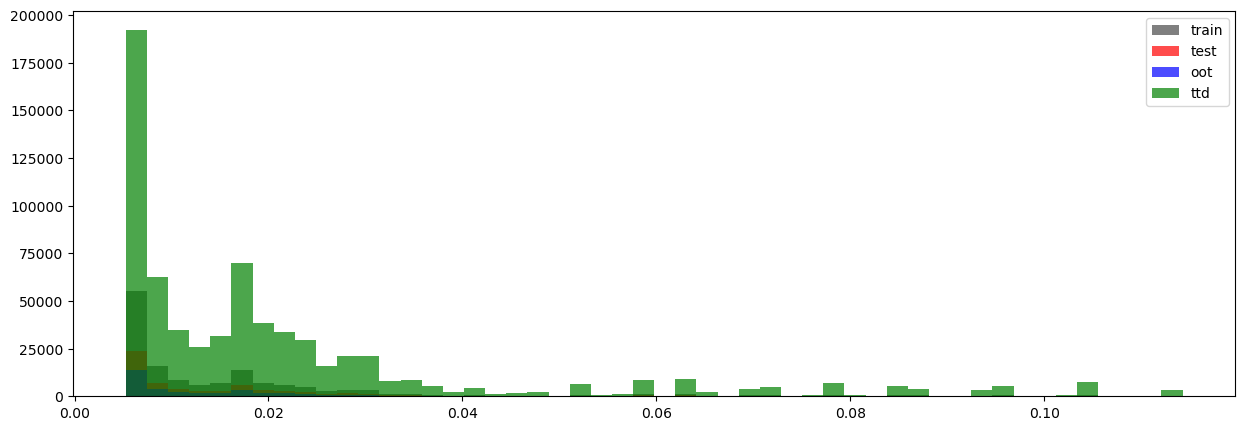

In [111]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [112]:
Train['p1'].value_counts(dropna= False).head()

p1
0.005289    12858
0.005929     5837
0.005857     5015
0.006586     3612
0.005875     3572
Name: count, dtype: int64

In [113]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]     141943
[1]       4543
[2]        337
[-1]        32
Name: count, dtype: int64
bankruptcystatus
[0]     60829
[1]      1941
[2]       157
[-1]       11
Name: count, dtype: int64


In [114]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [115]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetownership
inquiryauto12month
inquiryshortterm12month
sourcenonderogcount12month
assetpropevercount
inquirytelcom12month
sourcenonderogcount
derogcount
addrlastmovetaxratiodiff
inquirynonshortterm12month
addrcurrenttaxmarketvalue
addrinputtaxvalue
criminalnonfelonycount
evictioncount
derogcount12month
addrinputtimenewest
addrprevioustimeoldest
educationprogramattended
criminalfelonycount
educationattendance
addrinputlengthofres
addrcurrentblockratio
addrinputtaxmarketvalue
bankruptcydismissed24month
addrchangecount03month
inquirycollections12month
inquirybanking12month
bankruptcychapter
addrinputsubjectcount
addrchangecount24month
addrcurrentdeedmailing
addrinputdeedmailing
addrchangecount06month
lienjudgmentcount
lienjudgmentsmallclaimscount
addrpreviouslengthofres
bankruptcystatus
assetpropnewestmortgagetype
bankruptcycount24month
assetproppurchasetimeoldest
assetproppurchasetimenewest
criminalnonfelonycount12month
assetpersonalcount
addrchangecount60month
addrinputtimelastsale
a

In [116]:
pd.options.display.max_rows= 1000
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,assetownership,[0],1606.0,0.029652,0.030198,54162,691.0,0.029889,0.030367,23119.0,Yes
1,assetownership,[1],621.0,0.006700,0.008878,92693,268.0,0.006730,0.008884,39819.0,Yes
2,inquiryauto12month,[0],1496.0,0.011491,0.012411,130194,647.0,0.011612,0.012391,55716.0,Yes
3,inquiryauto12month,[1],731.0,0.043875,0.050581,16661,312.0,0.043201,0.050603,7222.0,Yes
4,inquiryshortterm12month,[0],2005.0,0.013959,0.016335,143630,882.0,0.014330,0.016383,61551.0,Yes
5,inquiryshortterm12month,[1],222.0,0.068837,0.034820,3225,77.0,0.055516,0.034190,1387.0,Yes
6,sourcenonderogcount12month,"[-inf, 2.0)",1730.0,0.023668,0.022178,73094,726.0,0.023263,0.022217,31209.0,Yes
7,sourcenonderogcount12month,"[2.0, inf)",497.0,0.006738,0.011353,73761,233.0,0.007343,0.011423,31729.0,Yes
8,assetpropevercount,"[-inf, 1.0)",1526.0,0.030046,0.030071,50788,663.0,0.030656,0.030245,21627.0,Yes
9,assetpropevercount,"[1.0, 2.0)",445.0,0.008564,0.010104,51963,204.0,0.009101,0.010164,22414.0,Yes


In [117]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Tower
30041 572.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.020352,0.114281,0.038002,6009,5708.0,301.0,5.01,20.0,19.37,52.62,33.25
1,0.012450,0.020352,0.016782,6008,5874.0,134.0,2.23,40.0,39.30,76.05,36.75
2,0.007291,0.012450,0.009073,6008,5926.0,82.0,1.36,60.0,59.41,90.38,30.97
3,0.005929,0.007291,0.006611,6008,5971.0,37.0,0.62,80.0,79.67,96.85,17.18
4,0.005289,0.005929,0.005621,6008,5990.0,18.0,0.30,100.0,100.00,100.00,0.00


{'Gini': 47.260000000000005, 'KS': 36.75}
GESA
19768 402.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.025515,0.114281,0.047728,3954,3762.0,192.0,4.86,20.0,19.43,47.76,28.33
1,0.018111,0.025470,0.021408,3954,3855.0,99.0,2.50,40.0,39.33,72.39,33.06
2,0.009939,0.018111,0.014488,3953,3874.0,79.0,2.00,60.0,59.34,92.04,32.70
3,0.006565,0.009939,0.007827,3954,3929.0,25.0,0.63,80.0,79.62,98.26,18.64
4,0.005289,0.006565,0.005872,3953,3946.0,7.0,0.18,100.0,100.00,100.00,0.00


{'Gini': 45.09, 'KS': 33.06}
Hawaii
1438 3.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022412,0.114281,0.036891,288,287.0,1.0,0.35,20.03,20.00,33.33,13.33
1,0.018111,0.022412,0.019834,288,288.0,0.0,0.00,40.06,40.07,33.33,6.74
2,0.014709,0.018111,0.016151,287,286.0,1.0,0.35,60.01,60.00,66.67,6.67
3,0.008158,0.014709,0.009942,288,288.0,0.0,0.00,80.04,80.07,66.67,13.40
4,0.005289,0.008158,0.006914,287,286.0,1.0,0.35,100.00,100.00,100.00,0.00


{'Gini': -0.05, 'KS': 13.4}
Guardian
19177 268.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.027018,0.114281,0.055309,3836,3698.0,138.0,3.60,20.0,19.56,51.49,31.93
1,0.018111,0.027018,0.021588,3835,3765.0,70.0,1.83,40.0,39.47,77.61,38.14
2,0.009095,0.018111,0.013383,3836,3801.0,35.0,0.91,60.0,59.57,90.67,31.10
3,0.006586,0.009095,0.007816,3835,3823.0,12.0,0.31,80.0,79.79,95.15,15.36
4,0.005289,0.006586,0.005935,3835,3822.0,13.0,0.34,100.0,100.00,100.00,0.00


{'Gini': 46.61, 'KS': 38.14}
SECU
12804 320.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024805,0.114281,0.051379,2561,2382.0,179.0,6.99,20.00,19.08,55.94,36.86
1,0.016469,0.024805,0.020178,2561,2487.0,74.0,2.89,40.00,39.00,79.06,40.06
2,0.008230,0.016469,0.012790,2561,2519.0,42.0,1.64,60.00,59.18,92.19,33.01
3,0.006505,0.008230,0.007046,2561,2541.0,20.0,0.78,80.01,79.53,98.44,18.91
4,0.005289,0.006505,0.005704,2560,2555.0,5.0,0.20,100.00,100.00,100.00,0.00


{'Gini': 51.54, 'KS': 40.06}
Arkansas
27867 167.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.018443,0.114281,0.035048,5574,5481.0,93.0,1.67,20.0,19.79,55.69,35.90
1,0.009914,0.018443,0.014064,5573,5542.0,31.0,0.56,40.0,39.79,74.25,34.46
2,0.007250,0.009914,0.008296,5574,5553.0,21.0,0.38,60.0,59.84,86.83,26.99
3,0.005929,0.007250,0.006526,5573,5558.0,15.0,0.27,80.0,79.91,95.81,15.90
4,0.005289,0.005929,0.005482,5573,5566.0,7.0,0.13,100.0,100.00,100.00,0.00


{'Gini': 45.300000000000004, 'KS': 35.9}
Numerica
18091 297.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.022483,0.114281,0.037682,3619,3488.0,131.0,3.62,20.0,19.60,44.11,24.51
1,0.014842,0.022483,0.018469,3618,3529.0,89.0,2.46,40.0,39.43,74.07,34.64
2,0.008230,0.014842,0.011047,3618,3575.0,43.0,1.19,60.0,59.53,88.55,29.02
3,0.006505,0.008230,0.007267,3618,3596.0,22.0,0.61,80.0,79.73,95.96,16.23
4,0.005289,0.006505,0.005868,3618,3606.0,12.0,0.33,100.0,100.00,100.00,0.00


{'Gini': 41.760000000000005, 'KS': 34.64}
CPM
6702 94.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019994,0.114281,0.037488,1341,1289.0,52.0,3.88,20.01,19.51,55.32,35.81
1,0.012252,0.019994,0.015894,1340,1320.0,20.0,1.49,40.00,39.48,76.60,37.12
2,0.007344,0.012252,0.009038,1341,1329.0,12.0,0.89,60.01,59.59,89.36,29.77
3,0.005929,0.007344,0.006644,1340,1333.0,7.0,0.52,80.01,79.77,96.81,17.04
4,0.005289,0.005929,0.005547,1340,1337.0,3.0,0.22,100.00,100.00,100.00,0.00


{'Gini': 47.9, 'KS': 37.12}
Bethpage
8328 63.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.019177,0.114281,0.035890,1666,1642.0,24.0,1.44,20.00,19.87,38.10,18.23
1,0.014662,0.019177,0.016564,1666,1654.0,12.0,0.72,40.01,39.88,57.14,17.26
2,0.007250,0.014662,0.009990,1665,1650.0,15.0,0.90,60.00,59.84,80.95,21.11
3,0.005857,0.007250,0.006241,1666,1657.0,9.0,0.54,80.01,79.89,95.24,15.35
4,0.005289,0.005857,0.005363,1665,1662.0,3.0,0.18,100.00,100.00,100.00,0.00


{'Gini': 28.78, 'KS': 21.11}
HFCU
2044 33.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.020273,0.114281,0.037406,409,397.0,12.0,2.93,20.01,19.74,36.36,16.62
1,0.014662,0.020273,0.017155,409,398.0,11.0,2.69,40.02,39.53,69.70,30.17
2,0.007344,0.014662,0.010305,409,402.0,7.0,1.71,60.03,59.52,90.91,31.39
3,0.005857,0.007344,0.006506,409,407.0,2.0,0.49,80.04,79.76,96.97,17.21
4,0.005289,0.005857,0.005408,408,407.0,1.0,0.25,100.00,100.00,100.00,0.00


{'Gini': 38.17, 'KS': 31.39}
NCU
595 8.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024140,0.114281,0.044797,120,115.0,5.0,4.17,20.17,19.59,62.5,42.91
1,0.016376,0.024137,0.019264,118,115.0,3.0,2.54,40.00,39.18,100.0,60.82
2,0.008230,0.016376,0.012805,120,120.0,0.0,0.00,60.17,59.63,100.0,40.37
3,0.005929,0.008230,0.007089,119,119.0,0.0,0.00,80.17,79.90,100.0,20.10
4,0.005289,0.005929,0.005545,118,118.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 65.72, 'KS': 60.82}


### Basic Checks

In [118]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(200148.0, 146855.0, 62938.0)

In [119]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [120]:
Train[(Train['id'].isin(TTD['id'].unique())) & (Train['client']!= 'CPM')].shape, Train[Train['client']!='CPM'].shape

((140153, 147), (140153, 147))

In [121]:
Test[(Test['id'].isin(TTD['id'].unique())) & (Test['client']!= 'CPM')].shape, Test[Test['client']!='CPM'].shape

((59995, 147), (59995, 147))

In [122]:
Train[(Train['id'].isin(Test['id'].unique()))].shape

(0, 147)

In [123]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    140153.000000
 mean          0.016828
 std           0.017377
 min           0.005289
 25%           0.006565
 50%           0.009939
 75%           0.020090
 max           0.114281
 Name: p1, dtype: float64,
 count    140153.000000
 mean          0.016828
 std           0.017377
 min           0.005289
 25%           0.006565
 50%           0.009939
 75%           0.020090
 max           0.114281
 Name: p1, dtype: float64)

In [124]:
Train['client'].value_counts(dropna= False)

client
Tower       30041
Arkansas    27867
GESA        19768
Guardian    19177
Numerica    18091
SECU        12804
Bethpage     8328
CPM          6702
HFCU         2044
Hawaii       1438
NCU           595
Name: count, dtype: int64

In [126]:
import datetime
pref= 'With_LDA'
Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)

In [127]:
TTD['fico_cut']= np.where(((TTD['fico_pb'].isnull()) |(TTD['fico_pb']<300)),"h.Missing",
                        np.where((TTD['fico_pb']>=300) &(TTD['fico_pb']<550),"a.300-550",
                                 np.where((TTD['fico_pb']>=550) &(TTD['fico_pb']<600),"a.550-600",
                                np.where((TTD['fico_pb']>=600) &(TTD['fico_pb']<630),"b.600-629",
                                    np.where((TTD['fico_pb']>=630) &(TTD['fico_pb']<660),"c.630-659",
                                        np.where((TTD['fico_pb']>=660) &(TTD['fico_pb']<690),"d.660-689",
                                            np.where((TTD['fico_pb']>=690) &(TTD['fico_pb']<715),"e.690-714",
                                                np.where((TTD['fico_pb']>=715) & (TTD['fico_pb']<740),"f.715-739",
                                                    np.where((TTD['fico_pb']>=740),"g.740+","h.Missing")))))))))

In [128]:
TTD.groupby('fico_cut').agg(
    ttd= ('unique_id', 'count'),
    approved= ('approve_flag', 'sum'),
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    avg_pd= ('p1', 'mean')
)

,ttd,approved,funded,bad,avg_pd
fico_cut,,,,,
a.300-550,35333,2873.0,1857.0,126.0,0.040587
a.550-600,52785,13360.0,5376.0,346.0,0.035570
b.600-629,57138,23516.0,7940.0,386.0,0.030811
c.630-659,78628,39076.0,15179.0,554.0,0.026094
d.660-689,90338,52831.0,24815.0,511.0,0.021728
e.690-714,73120,48229.0,23877.0,300.0,0.018532
f.715-739,62889,45175.0,23083.0,186.0,0.016756
g.740+,199076,167515.0,93215.0,243.0,0.011987
h.Missing,35908,9030.0,4806.0,395.0,0.030600


In [129]:
TTD.shape

(685215, 148)

In [5]:
!ls '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/'

050424_LN_Auto_KGB_LDA_No_Segment_Hopt_4.csv
With_LDA_Oot_Auto_LN_V2_Scored_Data_2024-04-08.csv
With_LDA_TTD_Auto_LN_V2_Scored_Data_2024-04-08.csv
With_LDA_Test_Auto_LN_V2_Scored_Data_2024-04-08.csv
With_LDA_Train_Auto_LN_V2_Scored_Data_2024-04-08.csv
xgbm_ln_auto_v2_hpt_best_with_lda_3.zip


In [6]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/'
pref= 'With_LDA'
train_scored= pd.read_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_2024-04-08.csv')
train_scored.shape

(146855, 12)

In [7]:
train_scored['3_digit_score']= train_scored['p1'].apply(convert_to_3_digit)
train_scored['3_digit_score'].describe()

count    146855.000000
mean        739.241769
std          32.163494
min         638.000000
25%         718.000000
50%         748.000000
75%         767.000000
max         776.000000
Name: 3_digit_score, dtype: float64

In [48]:
def get_fico_distribution(x):
    return pd.DataFrame(x.describe([0.05*i for i in range(1, 20)] + [0.99])).T#.to_dict(orient= 'records')

In [20]:
train_scored['p1'].describe([0.25, 0.9, 0.95, 0.99])

count    146855.000000
mean          0.016741
std           0.017298
min           0.005289
25%           0.006565
50%           0.009939
90%           0.030474
95%           0.057923
99%           0.095058
max           0.114281
Name: p1, dtype: float64

In [22]:
temp= []
for sc in sorted(train_scored['3_digit_score'].unique(), reverse= True):
    a= {}
    a['3_digit_score']= sc
    a['apps']= len(train_scored[train_scored['3_digit_score']== sc])
    a['min_pd']= train_scored[train_scored['3_digit_score']== sc]['p1'].min()
    a['mean_pd']= train_scored[train_scored['3_digit_score']== sc]['p1'].mean()
    a['median_pd']= train_scored[train_scored['3_digit_score']== sc]['p1'].median()
    a['max_pd']= train_scored[train_scored['3_digit_score']== sc]['p1'].max()
    
    desc= train_scored[train_scored['3_digit_score']== sc]['fico_pb'].describe([0.25, 0.75, 0.9, 0.95, 0.99])
    a['apps_c']= desc['count']
    a['fico_mean']= desc['mean']
    a['fico_min']= desc['min']
    a['fico_25%']= desc['25%']
    a['fico_50%']= desc['50%']
    a['fico_75%']= desc['75%']
    a['fico_90%']= desc['90%']
    a['fico_95%']= desc['95%']
    a['fico_99%']= desc['99%']
    a['fico_max']= desc['max']
    
    temp.append(a)

In [23]:
temp= pd.DataFrame(temp)

In [26]:
temp

,3_digit_score,apps,min_pd,mean_pd,median_pd,max_pd,apps_c,fico_mean,fico_min,fico_25%,fico_50%,fico_75%,fico_90%,fico_95%,fico_99%,fico_max
0,776,12858,0.005289,0.005289,0.005289,0.005289,12854.0,768.140968,0.0,724.00,775.0,816.75,848.0,862.00,882.00,900.0
1,772,6688,0.005842,0.005853,0.005857,0.005857,6686.0,764.598564,0.0,719.00,772.0,814.00,842.0,861.00,881.00,900.0
2,771,9553,0.005875,0.005909,0.005929,0.005929,9552.0,762.366206,0.0,717.00,773.0,815.00,846.0,863.00,882.00,900.0
3,770,1298,0.006006,0.006006,0.006006,0.006006,1297.0,752.902853,0.0,708.00,756.0,805.00,836.4,855.40,874.04,892.0
4,767,7512,0.006468,0.006528,0.006548,0.006565,7511.0,757.255625,0.0,713.00,766.0,808.00,837.0,855.00,880.00,900.0
5,766,5510,0.006586,0.006607,0.006586,0.006708,5506.0,760.191246,0.0,714.00,773.0,812.75,841.0,860.00,882.00,900.0
6,765,768,0.006732,0.006732,0.006732,0.006732,766.0,733.552219,0.0,685.00,738.0,793.00,826.5,843.75,870.70,888.0
7,763,2922,0.007080,0.007096,0.007080,0.007196,2922.0,757.022245,0.0,712.00,762.0,806.00,835.0,850.00,872.79,892.0
8,762,6769,0.007220,0.007289,0.007285,0.007367,6767.0,750.916063,0.0,708.00,759.0,804.00,832.0,850.00,875.00,896.0
9,761,1908,0.007386,0.007444,0.007441,0.007518,1908.0,736.993187,0.0,695.75,747.0,797.00,825.0,842.00,872.00,888.0


In [49]:
temp_fico= list(train_scored.groupby('p1')['fico_pb'].apply(lambda x: get_fico_distribution(x)).reset_index().to_dict(orient= 'records'))

In [50]:
temp_fico= pd.DataFrame(temp_fico)
temp_fico.head()

,p1,level_1,count,mean,std,min,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,99%,max
0,0.005289,0.005289,12854.0,768.140968,67.849312,0.0,661.0,683.0,699.0,712.0,724.00,736.0,747.00,756.0,765.0,775.0,784.0,793.0,801.00,808.0,816.75,825.0,835.00,848.0,862.00,882.00,900.0
1,0.005842,0.005842,1673.0,761.711297,70.522221,0.0,658.6,680.0,693.0,705.0,716.00,728.0,740.00,751.8,761.0,772.0,781.0,789.0,796.80,804.0,811.00,818.0,826.00,835.8,852.00,879.56,900.0
2,0.005857,0.005857,5013.0,765.562138,67.425810,0.0,660.0,679.2,696.0,708.0,720.00,733.0,743.00,753.0,762.0,772.0,781.0,791.0,798.00,807.0,815.00,824.0,833.00,845.0,862.00,881.00,900.0
3,0.005875,0.005875,3571.0,764.692523,75.550047,0.0,654.0,682.0,697.0,710.0,723.00,734.0,745.00,754.0,764.0,774.0,784.0,793.0,801.00,808.0,815.00,823.0,831.00,840.0,860.00,880.00,895.0
4,0.005907,0.005907,144.0,783.826389,60.051299,609.0,671.3,700.0,715.7,729.6,745.75,753.0,765.05,776.2,786.0,794.5,804.0,811.0,816.95,821.0,831.25,837.0,842.65,851.0,862.85,883.13,891.0


In [51]:
temp_fico= temp_fico.sort_values(by= ['count'], ascending = False).reset_index(drop= True)

In [52]:
temp_fico.head(20)

,p1,level_1,count,mean,std,min,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%,85%,90%,95%,99%,max
0,0.005289,0.005289,12854.0,768.140968,67.849312,0.0,661.00,683.0,699.00,712.0,724.0,736.0,747.0,756.0,765.0,775.0,784.0,793.0,801.00,808.0,816.75,825.0,835.0,848.0,862.00,882.00,900.0
1,0.005929,0.005929,5837.0,760.413569,83.538153,0.0,646.00,672.0,688.00,702.0,714.0,726.0,738.0,750.0,760.0,771.0,780.8,789.0,798.00,807.0,814.00,824.0,834.0,848.0,864.20,883.00,900.0
2,0.005857,0.005857,5013.0,765.562138,67.425810,0.0,660.00,679.2,696.00,708.0,720.0,733.0,743.0,753.0,762.0,772.0,781.0,791.0,798.00,807.0,815.00,824.0,833.0,845.0,862.00,881.00,900.0
3,0.006586,0.006586,3609.0,765.342754,75.489219,0.0,647.00,672.0,688.00,703.0,716.0,730.0,744.0,758.0,770.0,780.0,789.0,797.0,805.00,810.0,817.00,826.0,834.0,847.0,864.00,883.92,900.0
4,0.005875,0.005875,3571.0,764.692523,75.550047,0.0,654.00,682.0,697.00,710.0,723.0,734.0,745.0,754.0,764.0,774.0,784.0,793.0,801.00,808.0,815.00,823.0,831.0,840.0,860.00,880.00,895.0
5,0.014842,0.014842,3327.0,672.389841,183.751984,0.0,0.00,599.0,629.00,648.0,661.0,672.0,682.0,692.0,701.0,710.0,720.0,730.0,741.00,751.0,761.00,774.0,787.1,803.0,819.00,849.48,892.0
6,0.016469,0.016469,2581.0,687.322356,153.868181,0.0,543.00,609.0,637.00,652.0,665.0,675.0,684.0,693.0,703.0,714.0,723.0,733.0,742.00,753.0,763.00,774.0,787.0,801.0,817.00,849.20,896.0
7,0.007080,0.007080,2463.0,758.544458,62.502786,490.0,653.00,675.0,690.00,702.0,714.0,724.0,734.0,744.0,754.9,763.0,771.0,781.0,789.00,798.0,807.00,816.0,826.0,838.0,852.00,873.00,892.0
8,0.018111,0.018111,2189.0,646.366834,209.544632,0.0,0.00,553.8,608.20,634.0,649.0,659.0,670.0,680.0,689.0,698.0,707.0,717.0,728.20,739.0,751.00,766.0,781.0,796.2,815.00,836.00,888.0
9,0.006565,0.006565,1811.0,757.948095,81.030733,0.0,647.00,672.0,686.00,699.0,712.0,723.0,736.0,746.0,757.0,767.0,777.0,786.0,794.00,803.0,810.00,819.0,830.0,842.0,862.00,880.00,900.0


In [ ]:
train_scored.groupby('p1').apply(
    lambda x: x.describe([0.05*i for i in range(1, 20)] + [0.99]
                        ).sort_values(by= 'funded_flag', ascending= False).head(20)